# Pivot and Graph Functions

This chapter will demonstrate how to use functions to simplify the Plotly graphing process. These functions will also prove useful within the online visualizations section of Python for Nonprofits.

## The motivation behind this chapter

As shown in the Graphing chapter, pivot tables play a crucial role in generating Plotly charts. They allow you to turn a raw dataset into a table of aggregate values that can easily be rendered as a bar graph, line graph, or some other chart type.

Thanks to the powerful Pandas library, these pivot tables are easy to produce within Python. However, creating separate pivot tables for each graph still requires a decent amount of work. In addition, there are times when coding these pivot tables would be impractical. 

Suppose, for instance, that you're putting together an online dashboard that visualizes mean NVCU survey result scores in bar chart form. You would like to allow users to compare these scores by up to 6 potential variables: starting year, season, gender, graduation Year, college, and level. (In other words, they should be able to view these results by season and college; college, level, and season; all six variables together; and even no variables at all--in which case the mean survey score will be displayed within a single bar.)

If you wanted to create a pivot table for each of these comparison options, you'd end up having to construct over 60 tables. (There are 6 comparison options, each of which can either be present or absent--resulting in a total of 2^6 = 64 tables.) In order to avoid the time-consuming task of pre-rendering all of these tables, we'll need to utilize **an 'autopivot' function that, given a list of comparison variables, a y variable, and a color variable, returns a pivot table, x and y variables, and a color variable.** We will demonstrate such a function within this notebook. 

Although this pivot table function will play a pivotal (pun intended) role in our final graph, we'll also need to create a corresponding **'autobar' function that converts the output of the autopivot function into a graph.** (We could add this code into our main pivot table function, but separating the two allows other graph types--such as line charts--to be created rather than bar charts, thus making the code more versatile.)

In [1]:
import pandas as pd
import plotly.express as px
from sqlalchemy import create_engine
e = create_engine('sqlite:///../Appendix/nvcu_db.db')

import sys
sys.path.insert(1, '../Appendix')
from helper_funcs import config_notebook, wadi
display_type = config_notebook(display_max_columns = 5)
        

## Creating a detailed survey results dataset

This dataset will include data from both our survey results *and* enrollment tables, thus allowing for additional comparison options.

### Importing each dataset:

In [2]:
df_enrollment = pd.read_sql(
    'select * from curr_enrollment', con=e)
df_enrollment.head()

first_name   last_name  ... level  level_for_sorting
0     Amanda      Murphy  ...    Se                  3
1      Terri  Washington  ...    Se                  3
2    Crystal       Davis  ...    Se                  3
3    Theresa      Joseph  ...    Se                  3
4    Chelsea      Martin  ...    Se                  3

[5 rows x 11 columns]

In [3]:
df_survey_results = pd.read_sql(
    'select * from survey_results', con=e)
df_survey_results.head()

student_id  starting_year season  score
0     2020-1           2023   Fall     88
1     2020-2           2023   Fall     37
2     2020-3           2023   Fall     54
3     2020-4           2023   Fall     56
4     2020-5           2023   Fall     77

### Merging these datasets together:

In [4]:
df_se = df_survey_results.merge(
    df_enrollment, on='student_id', how='left')
# The 'se' in df_se stands for 'survey and enrollment.'

# Removing columns that we're not interested in using for our 
# comparisons:
df_se.drop(
    ['student_id', 'first_name', 'last_name',
     'date_of_birth', 'matriculation_number'], 
    axis=1, inplace=True)

# Reformatting our column names so that they'll show up better
# within graphs):

df_se.columns = [
    column.replace('_', ' ').title() 
    for column in df_se.columns]

df_se['Season For Sorting'] = (
    df_se[
'Season'].map({'Fall':0,'Winter':1,'Spring':2}))
df_se.sort_values(
    ['Season For Sorting', 'Level For Sorting'],
    inplace=True)

df_se.head()


Starting Year Season  ...  Level For Sorting Season For Sorting
10941           2023   Fall  ...                  0                  0
10942           2023   Fall  ...                  0                  0
10943           2023   Fall  ...                  0                  0
10944           2023   Fall  ...                  0                  0
10945           2023   Fall  ...                  0                  0

[5 rows x 10 columns]

In [5]:
df_se['Responses'] = 1
df_se_pivot = df_se.pivot_table(
    index=['Starting Year', 'Season', 'Gender', 
             'Matriculation Year', 'College', 'Class Of',
             'Level', 'Level For Sorting', 'Season For Sorting'],
    values=['Score', 'Responses'],
    aggfunc={'Score':'mean', 'Responses':'sum'}).reset_index()
df_se_pivot

Starting Year  Season  ... Responses      Score
0            2023    Fall  ...       408  69.583333
1            2023    Fall  ...       519  69.697495
..            ...     ...  ...       ...        ...
62           2023  Spring  ...       756  79.120370
63           2023  Spring  ...       858  78.083916

[64 rows x 11 columns]

## A basic autopivot function

The following code shows a simple version of an 'autopivot' function that can automatically create both pivot tables to be graphed and corresponding graphing variables. (This table and corresponding variables can then be sent to a graphing function like `px.bar()`.) One key variable generated by this function is a field that groups together all of the individual comparison values passed to x_vars[] and can thus serve as the 'x' argument within a Plotly graph call.

This function has a number of limitations: for instance, it doesn't take color options into account, and it also can't accommodate variables that should be included in the *pivot table* function (e.g. for sorting purposes) but excluded from the *x variable column*. However, I chose to include it here in order to highlight the core concepts of this 'autopivot' function. (The final autopivot function will be somewhat more complicated.)

In [6]:
def autopivot_simple(df, y, aggfunc, x_vars=[],
                    overall_data_name='All Data'):
    '''This is a simple version of an 'autopivot' chart. Given a 
    DataFrame, a y variable, an aggregate function, and an arbitrary list 
    of variables, it will return a pivot table, an x variable, 
    and a y variable that can then get fed into a graphing function.

    For more documentation on these steps, 
    see the full autopivot function within auto_pivot_and_graph.py,
    which is located within the PFN_Dash_App_Demo section of PFN. 
    (I excluded that documentation from this code in order to 
    avoid redundancy.)
    '''

    df_for_pivot = df.copy()
    df_for_pivot

    # Handling a situation in which no comparion variables were provided:
    if len(x_vars) == 0: 
        df_for_pivot[overall_data_name] = overall_data_name
        df_pivot = df_for_pivot.pivot_table(
            index=overall_data_name, values=y, 
            aggfunc=aggfunc).reset_index()
        x_val_name = overall_data_name
        color = overall_data_name
        barmode = 'relative'
        index = [overall_data_name]         
       
    else:
        print("x_vars:",x_vars)    

        # Creating a pivot table using the arguments provided:
        df_pivot = df_for_pivot.pivot_table(
            index=x_vars, values=y, aggfunc=aggfunc).reset_index()
        
        # Creating the x variable's column name:
        # (This name can then get fed into a graphing function.)
        x_val_name = ('/').join(x_vars)

        # Creating the values for the x_val_name column:
        # (The function does so by combining each row's values for 
        # the fields represented in x_vars into a single string.)
        # It starts with the first x variable provided, then loops
        # through the rest of x_vars to add in the others.
        df_pivot[x_val_name] = df_pivot[x_vars[0]].astype('str')
        for i in range(1, len(x_vars)):
            df_pivot[x_val_name] = (
                df_pivot[x_val_name] 
                + '/' + df_pivot[x_vars[i]].astype('str'))
            
    return df_pivot, x_val_name, y, aggfunc

## A basic autobar function

The following function uses the output of `autopivot_simple()` as inputs for a bar chart. It's quite limited relative to the final autobar function that will be applied later in this code, but it still demonstrates the utility of the `autopivot_simple()` function.

In [7]:
def autobar_simple(df_pivot, x_val_name, y, aggfunc):
    '''This function creates a bar graph of a pivot table (such as one
    created by autopivot_simple.
    For more documentation on this function, view the full autobar()
    function within within auto_pivot_and_graph.py.
    '''
    
    fig = px.bar(df_pivot, x=x_val_name, y=y, text_auto='.0f',
                title=f"{aggfunc.title()} {y} by {x_val_name}") 
    return fig

## Testing out `autopivot_simple()` and `autobar_simple()`

Let's try using these functions to graph average survey results by level and season. First, we'll call `autopivot_simple()` to generate inputs for `autobar_simple()`:

In [8]:
df_pivot, x_val_name, y, aggfunc = autopivot_simple(
    df_se, y='Score', aggfunc='mean', x_vars=['Level', 'Season'])

print(x_val_name, y, df_pivot.head())

x_vars: ['Level', 'Season']
Level/Season Score   Level  Season      Score Level/Season
0    Fr    Fall  69.609774      Fr/Fall
1    Fr  Spring  74.833180    Fr/Spring
2    Ju    Fall  69.768957      Ju/Fall
3    Ju  Spring  69.350671    Ju/Spring
4    Se    Fall  69.698085      Se/Fall


Next, we'll call autobar_simple() to convert these values into a bar chart:

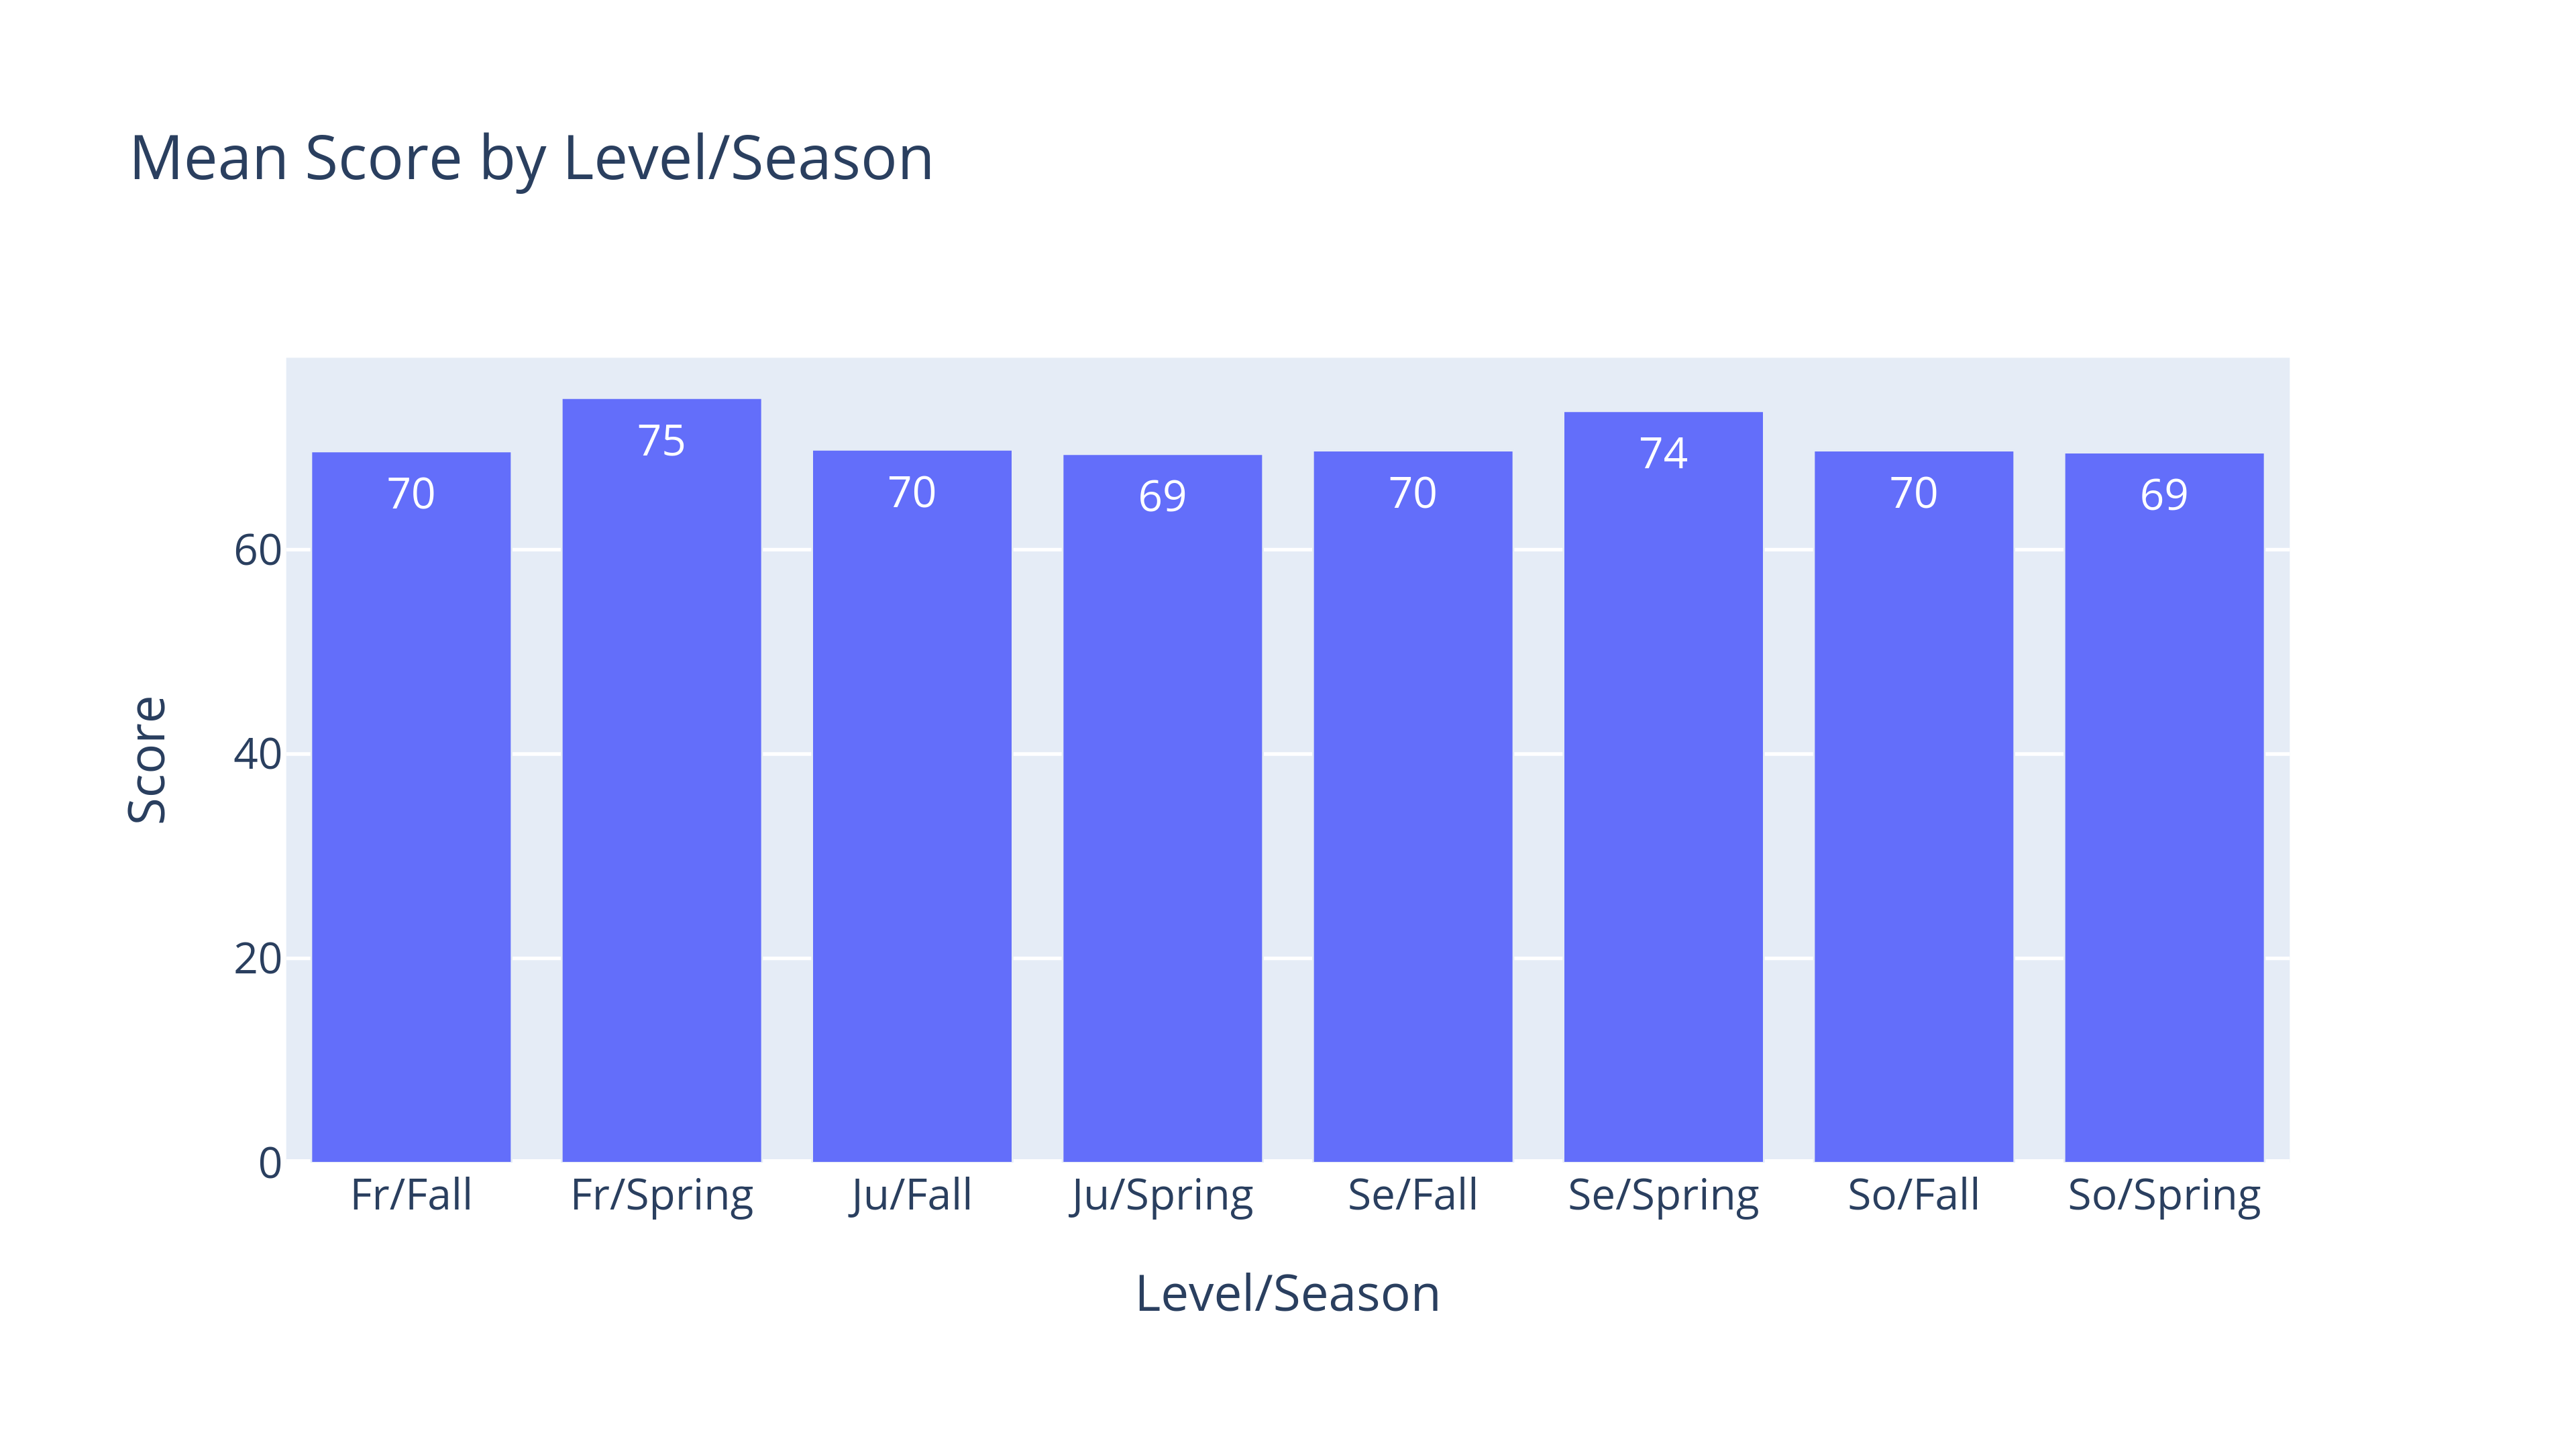

In [9]:
fig = autobar_simple(
    df_pivot=df_pivot, x_val_name=x_val_name, y=y,
aggfunc=aggfunc)                      

wadi(fig=fig, file_path='output/mean_score_by_level_and_season',
    display_type=display_type)

Note that we only needed to specify our chart parameters within `autopivot_simple()`; its output could then get passed to `autobar_simple()` without any further tweaking.

Let's try simplifying the process of creating these charts even more by defining a function called `autopivot_plus_bar_simple()`. This function, given the same list of inputs that we passed to `autopivot_simple()`, will call `autopivot_simple()` to create a pivot table, then immediately call `autobar_simple()` to generate a corresponding bar chart. It will then return both outputs for further use.

In [10]:
def autopivot_plus_bar_simple(df, y, aggfunc, x_vars=[],
                    overall_data_name='All Data'):
    '''This function calls both autopivot_simple() and autobar_simple()
    in order to create both a pivot table and a bar.'''
    df_pivot, x_val_name, y, aggfunc = autopivot_simple(
        df=df, y=y, aggfunc=aggfunc, x_vars=x_vars,
                    overall_data_name=overall_data_name)
    fig = autobar_simple(df_pivot=df_pivot, x_val_name=x_val_name, y=y,
                         aggfunc=aggfunc)       
    return df_pivot, fig

We can now create the same figure shown above, along with its corresponding pivot table, using a single function call. The following output shows what this pivot table looks like:

In [11]:
df_pivot, fig = autopivot_plus_bar_simple(
    df_se, y='Score', aggfunc='mean', x_vars=['Level', 'Season'])
df_pivot.head()

x_vars: ['Level', 'Season']


Level  Season      Score Level/Season
0    Fr    Fall  69.609774      Fr/Fall
1    Fr  Spring  74.833180    Fr/Spring
2    Ju    Fall  69.768957      Ju/Fall
3    Ju  Spring  69.350671    Ju/Spring
4    Se    Fall  69.698085      Se/Fall

And here's the image--which is identical to the one we created earlier.

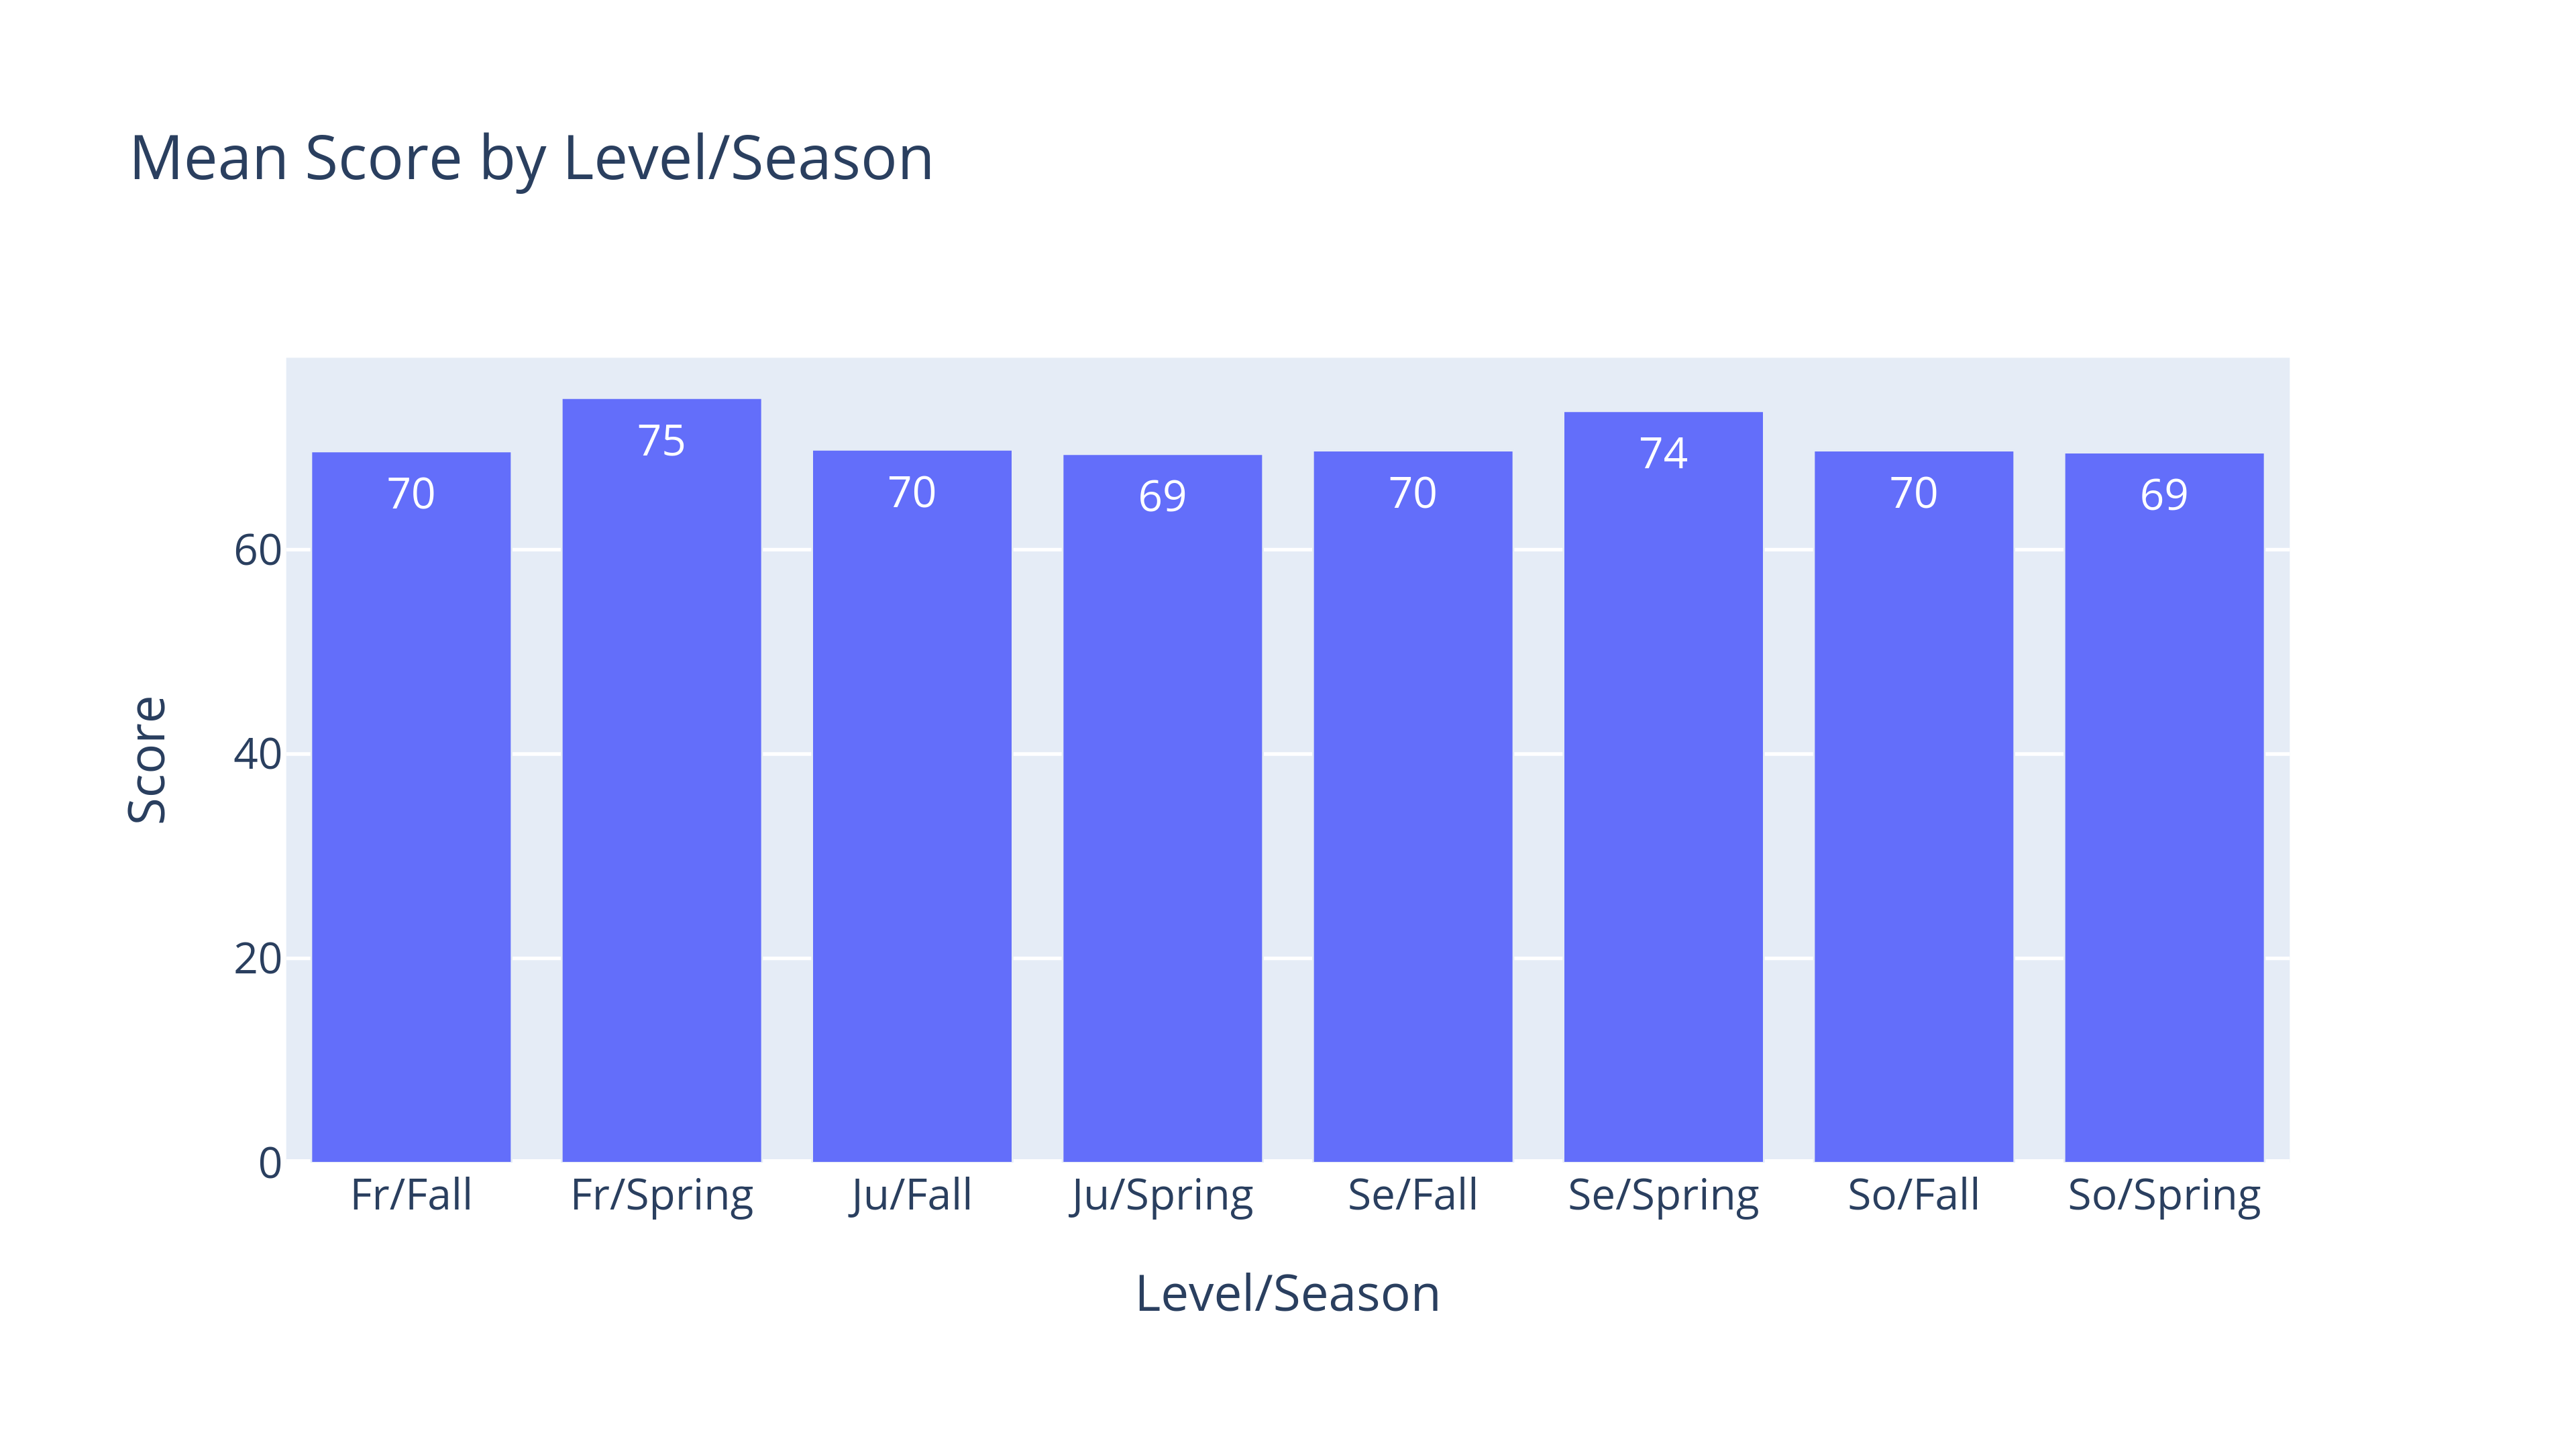

In [12]:
wadi(fig=fig, file_path='output/mean_score_by_level_and_season',
    display_type=display_type)

Next, we'll call `autopivot_plus_bar_simple()` to display average scores by season, college, and level:

x_vars: ['Season', 'College', 'Level']


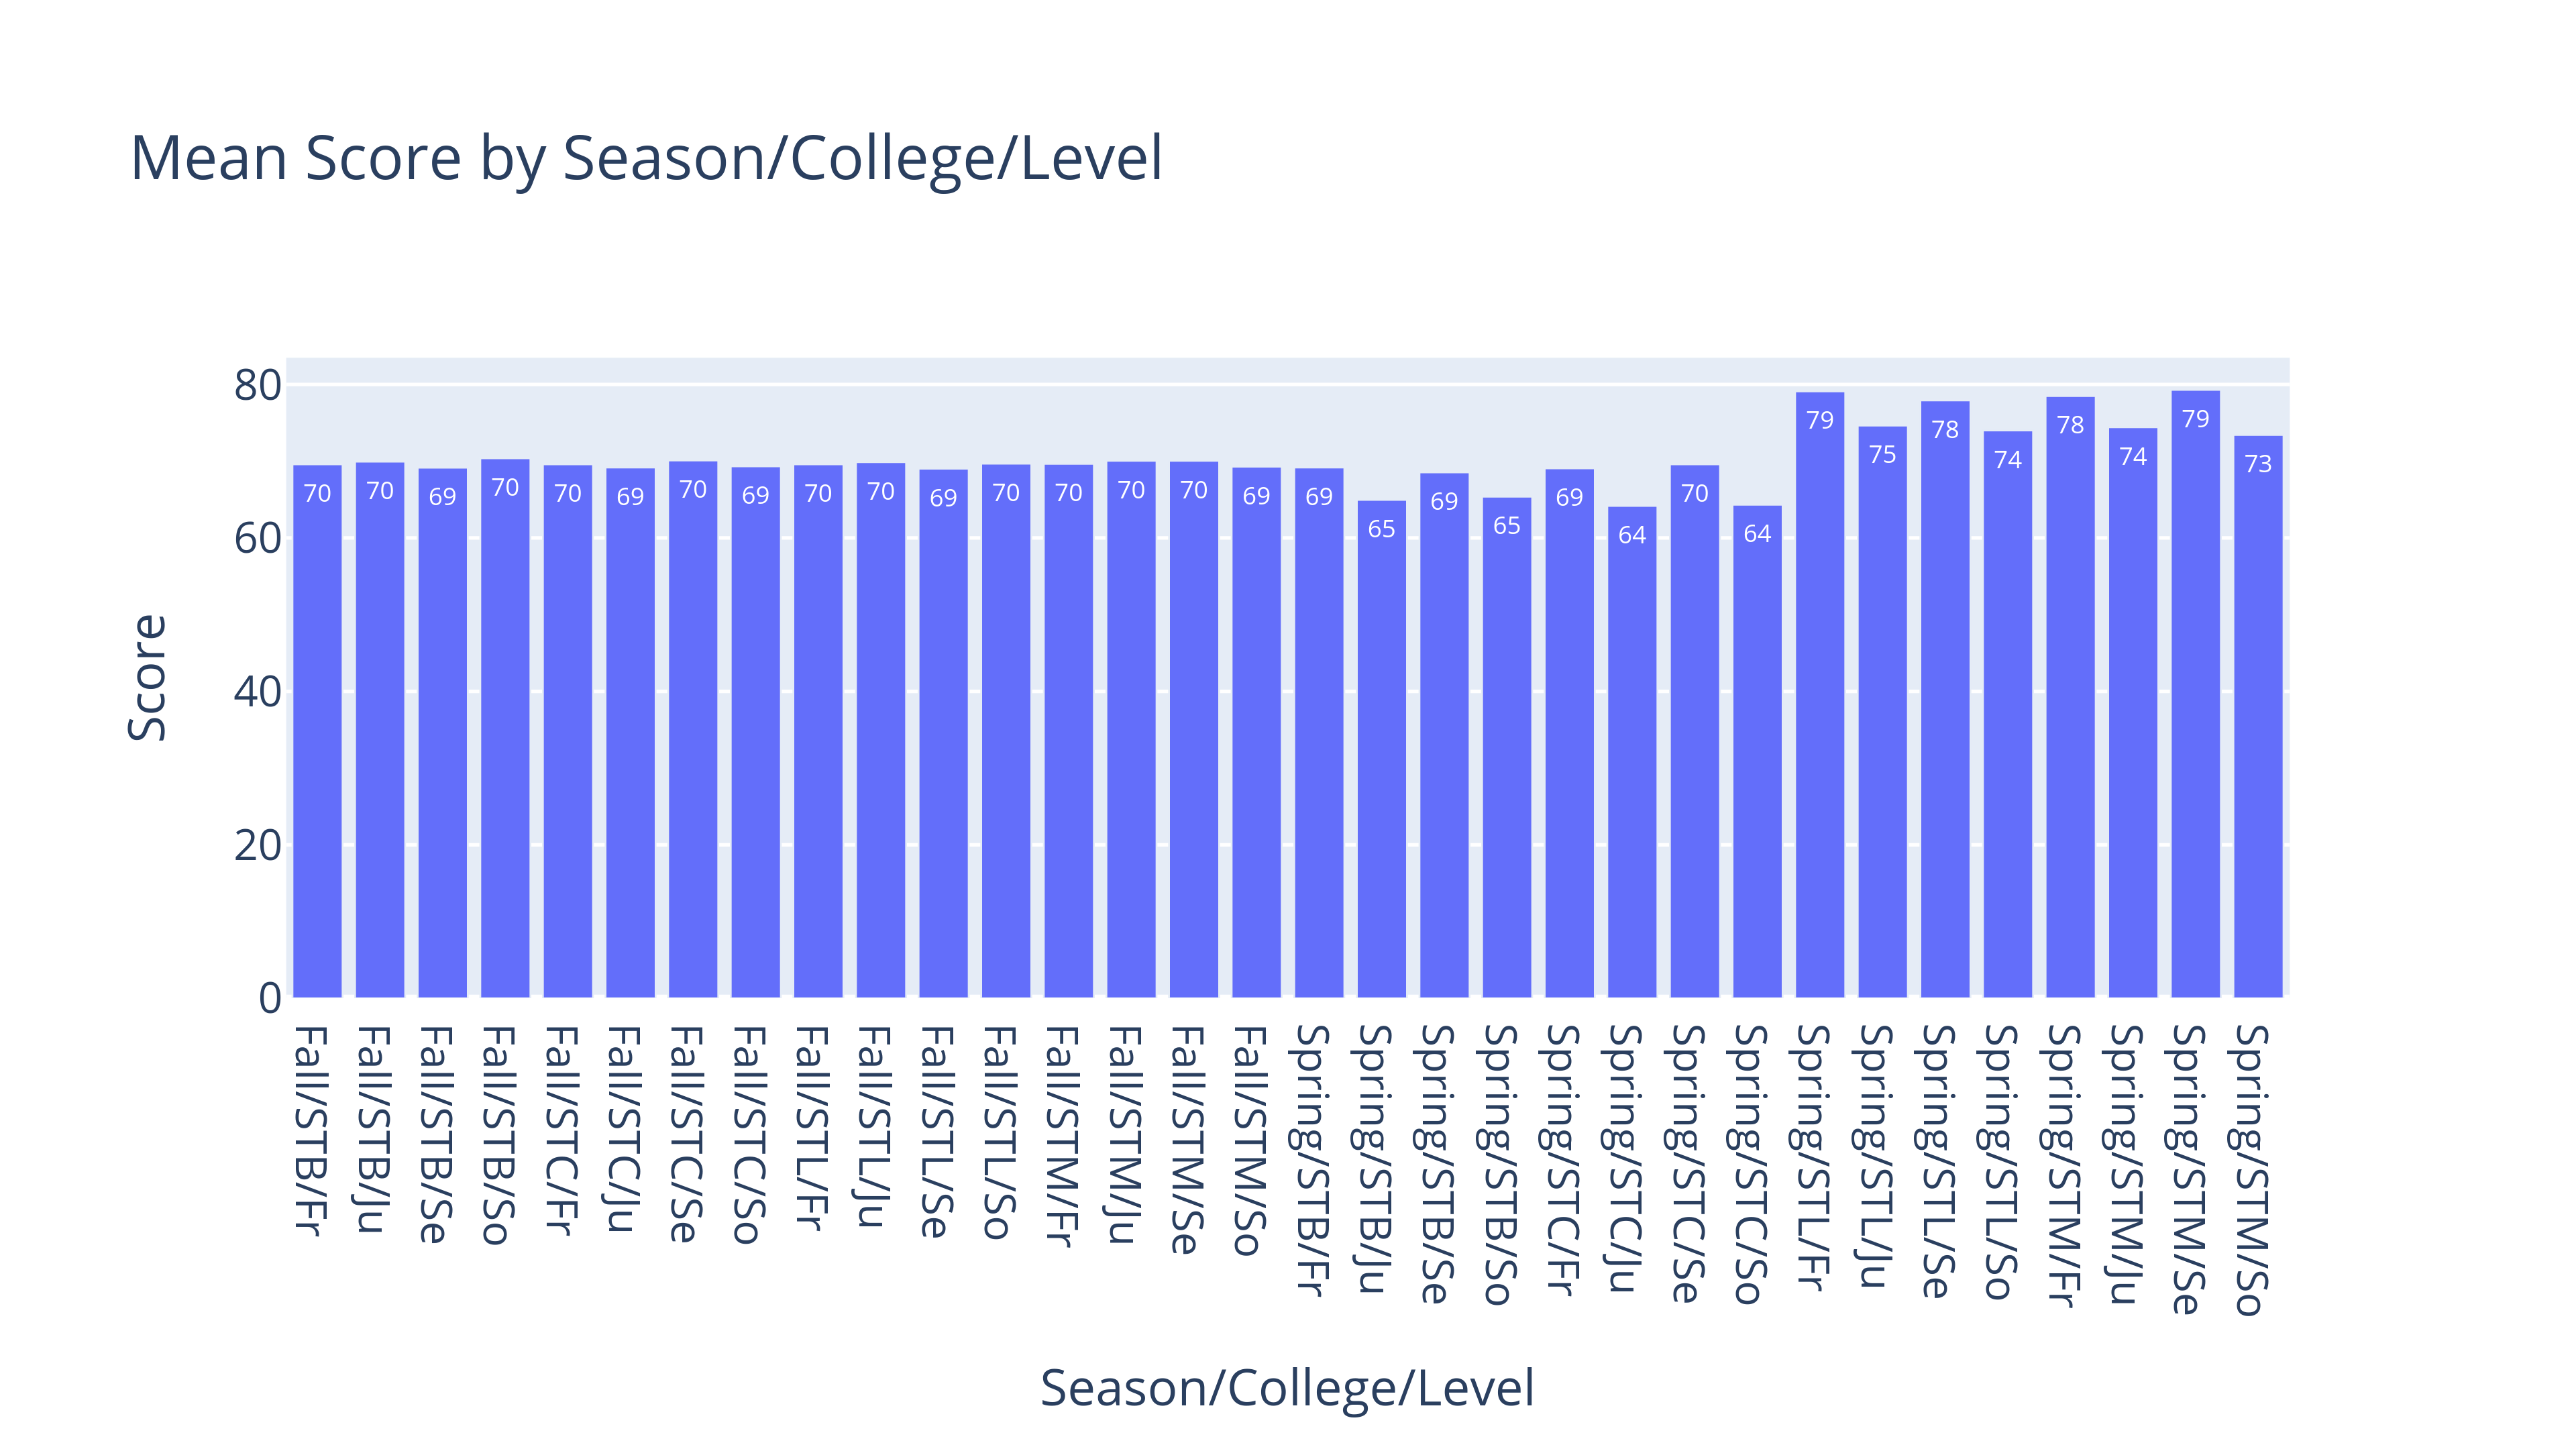

In [13]:
df_pivot, fig = autopivot_plus_bar_simple(
    df_se, y='Score', aggfunc='mean', x_vars=[
        'Season', 'College', 'Level'])

wadi(fig=fig, file_path='output/mean_score_by_season_college_and_level',
    display_type=display_type)

This chart would be both easier to interpret and more aesthetically pleasing with some color. Our simple autopivot and autobar functions don't handle color values, but their full-fledged versions, which we'll import shortly, do.

Finally, we'll create a chart that groups all data together:

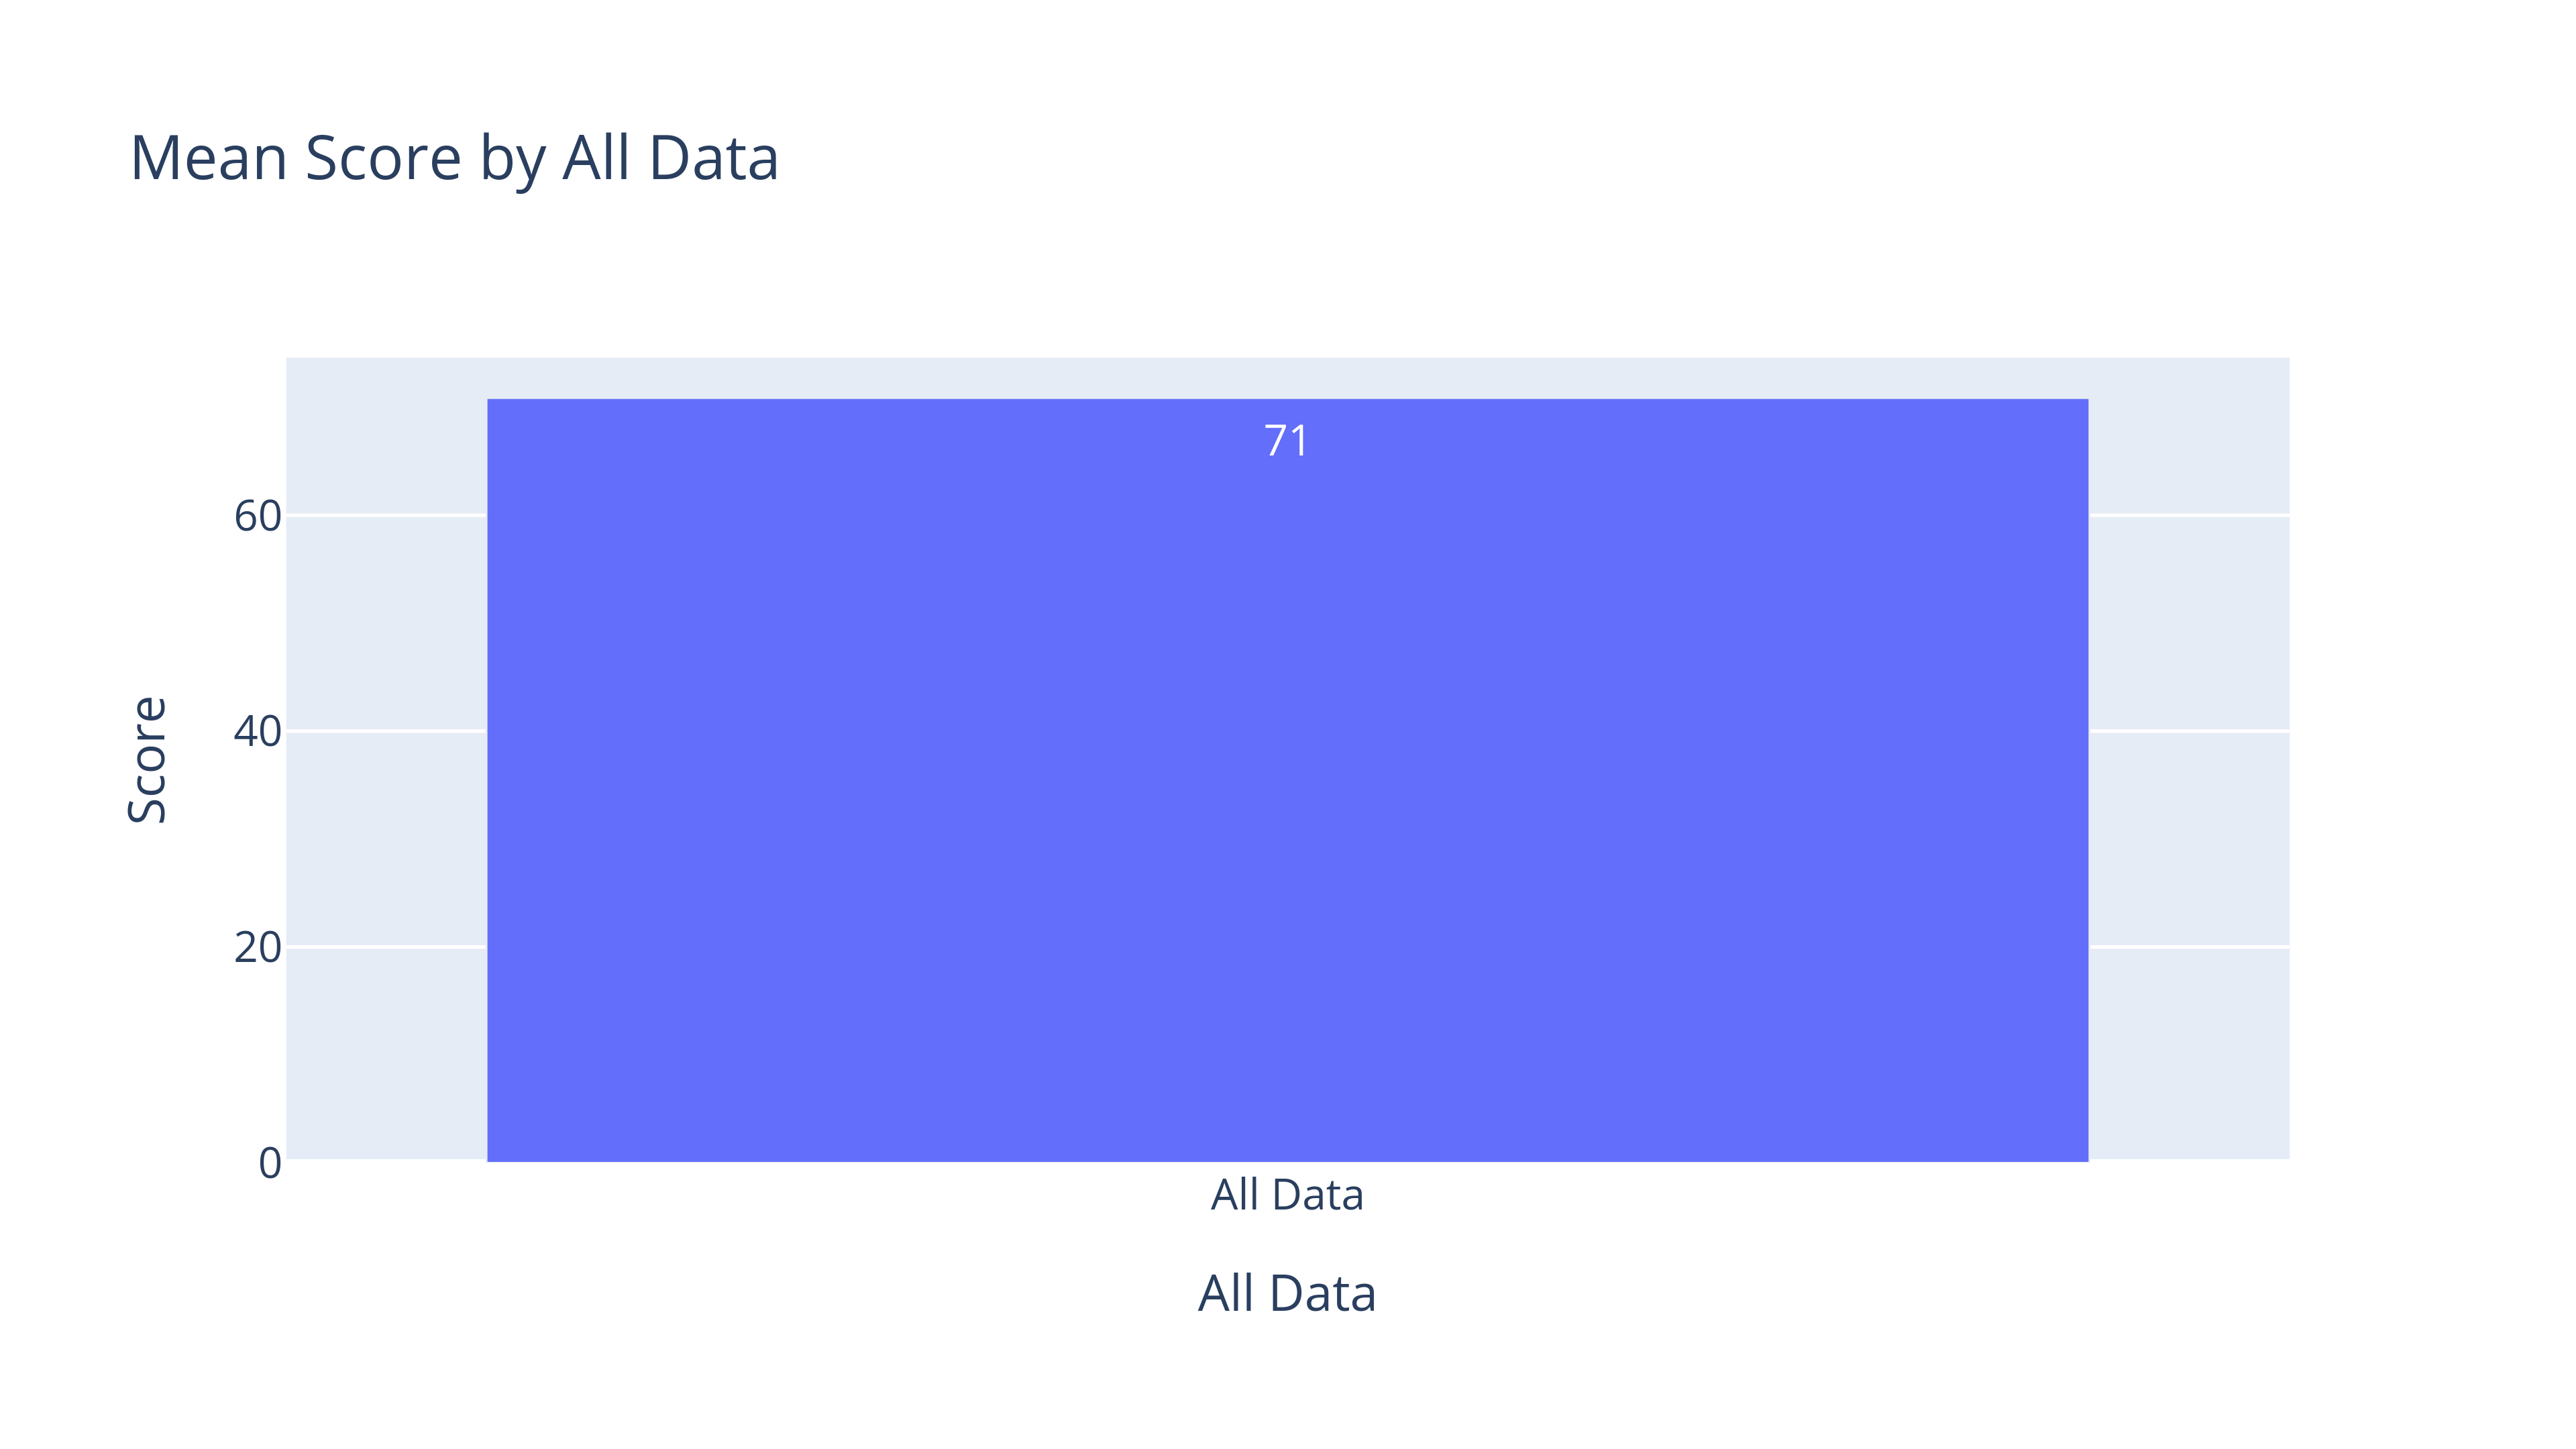

In [14]:
df_pivot, fig = autopivot_plus_bar_simple(
    df_se, y='Score', aggfunc='mean', x_vars=[])     

wadi(fig=fig, file_path='output/mean_score_by_all_data',
    display_type=display_type)

The above examples demonstrate how the `autopivot_simple()` and `autobar_simple()` functions can work together to generate all kinds of different table and chart combinations, thus eliminating the need to write pivot table and bar chart code for each set of comparison variables a user might want to analyze. 

However, the basic charts that they produce leave much to be desired. There are no colors: the titles could use some work; and levels are sorted alphabetically rather than chronologically. Therefore, we'll now import more robust versions of these functions.

## Importing autopivot and autobar functions 

These functions are stored within the 'auto_pivot_and_graph.py' file within the PFN_Dash_App_Demo component of PFN's Online Visualizations section. The Dash App Demo project applies them to automatically create new pivot tables--and corresponding charts--based on the input variables requested by dashboard visitors. 

I had originally kept a copy of these functions within this section as well, but that resulted in two redundant Python files that I would need to manually synchronize. Therefore, I decided to delete this section's copy and instead direct readers to the Online Visualizations section if they needed to reference the code.

At this point, I *do* suggest that you take some time to look through the auto_pivot_and_graph.py file; it contains detailed commentary to help you understand what's going on within each step. 

In [15]:
sys.path.insert(2, '../Online_Visualizations/PFN_Dash_App_Demo')
from auto_pivot_and_graph import autopivot, autobar, autopivot_plus_bar

### Demonstrating these functions

Let's try using these functions to graph average scores by the college, level, and season fields--just as we did in our previous chart. In order to simplify our x axis values (and improve the chart's appearance), we'll pass `Season` to this function's `color` parameter. In addition, although we're passing `Level For Sorting` to our `x_vars` argument (so that levels will appear within the correct order), we won't want that argument to show up within our x axis labels, so we'll add that value to `x_vars_to_exclude`. 

First, here's a look at the output of `autopivot()` on its own:

In [16]:
(df_pivot, x_val_name, y, color, barmode, 
 x_var_count, index, aggfunc) = autopivot(
    df=df_se, y='Score', 
    x_vars=['College', 'Level For Sorting', 'Level'], 
    color='Season', 
    x_vars_to_exclude=['Level For Sorting'],
    aggfunc='mean')
print(x_val_name, y, color, barmode)
df_pivot.head(5)

x_vars: ['College', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['College', 'Level For Sorting', 'Level', 'Season']
College/Level Score Season group


College  Level For Sorting  ...      Score College/Level
0     STB                  0  ...  69.593583        STB/Fr
1     STB                  0  ...  69.177235        STB/Fr
2     STB                  1  ...  70.377306        STB/So
3     STB                  1  ...  65.377306        STB/So
4     STB                  2  ...  69.950769        STB/Ju

[5 rows x 6 columns]

And here's what `autobar()` produces when provided the arguments generated within `autopivot()`:

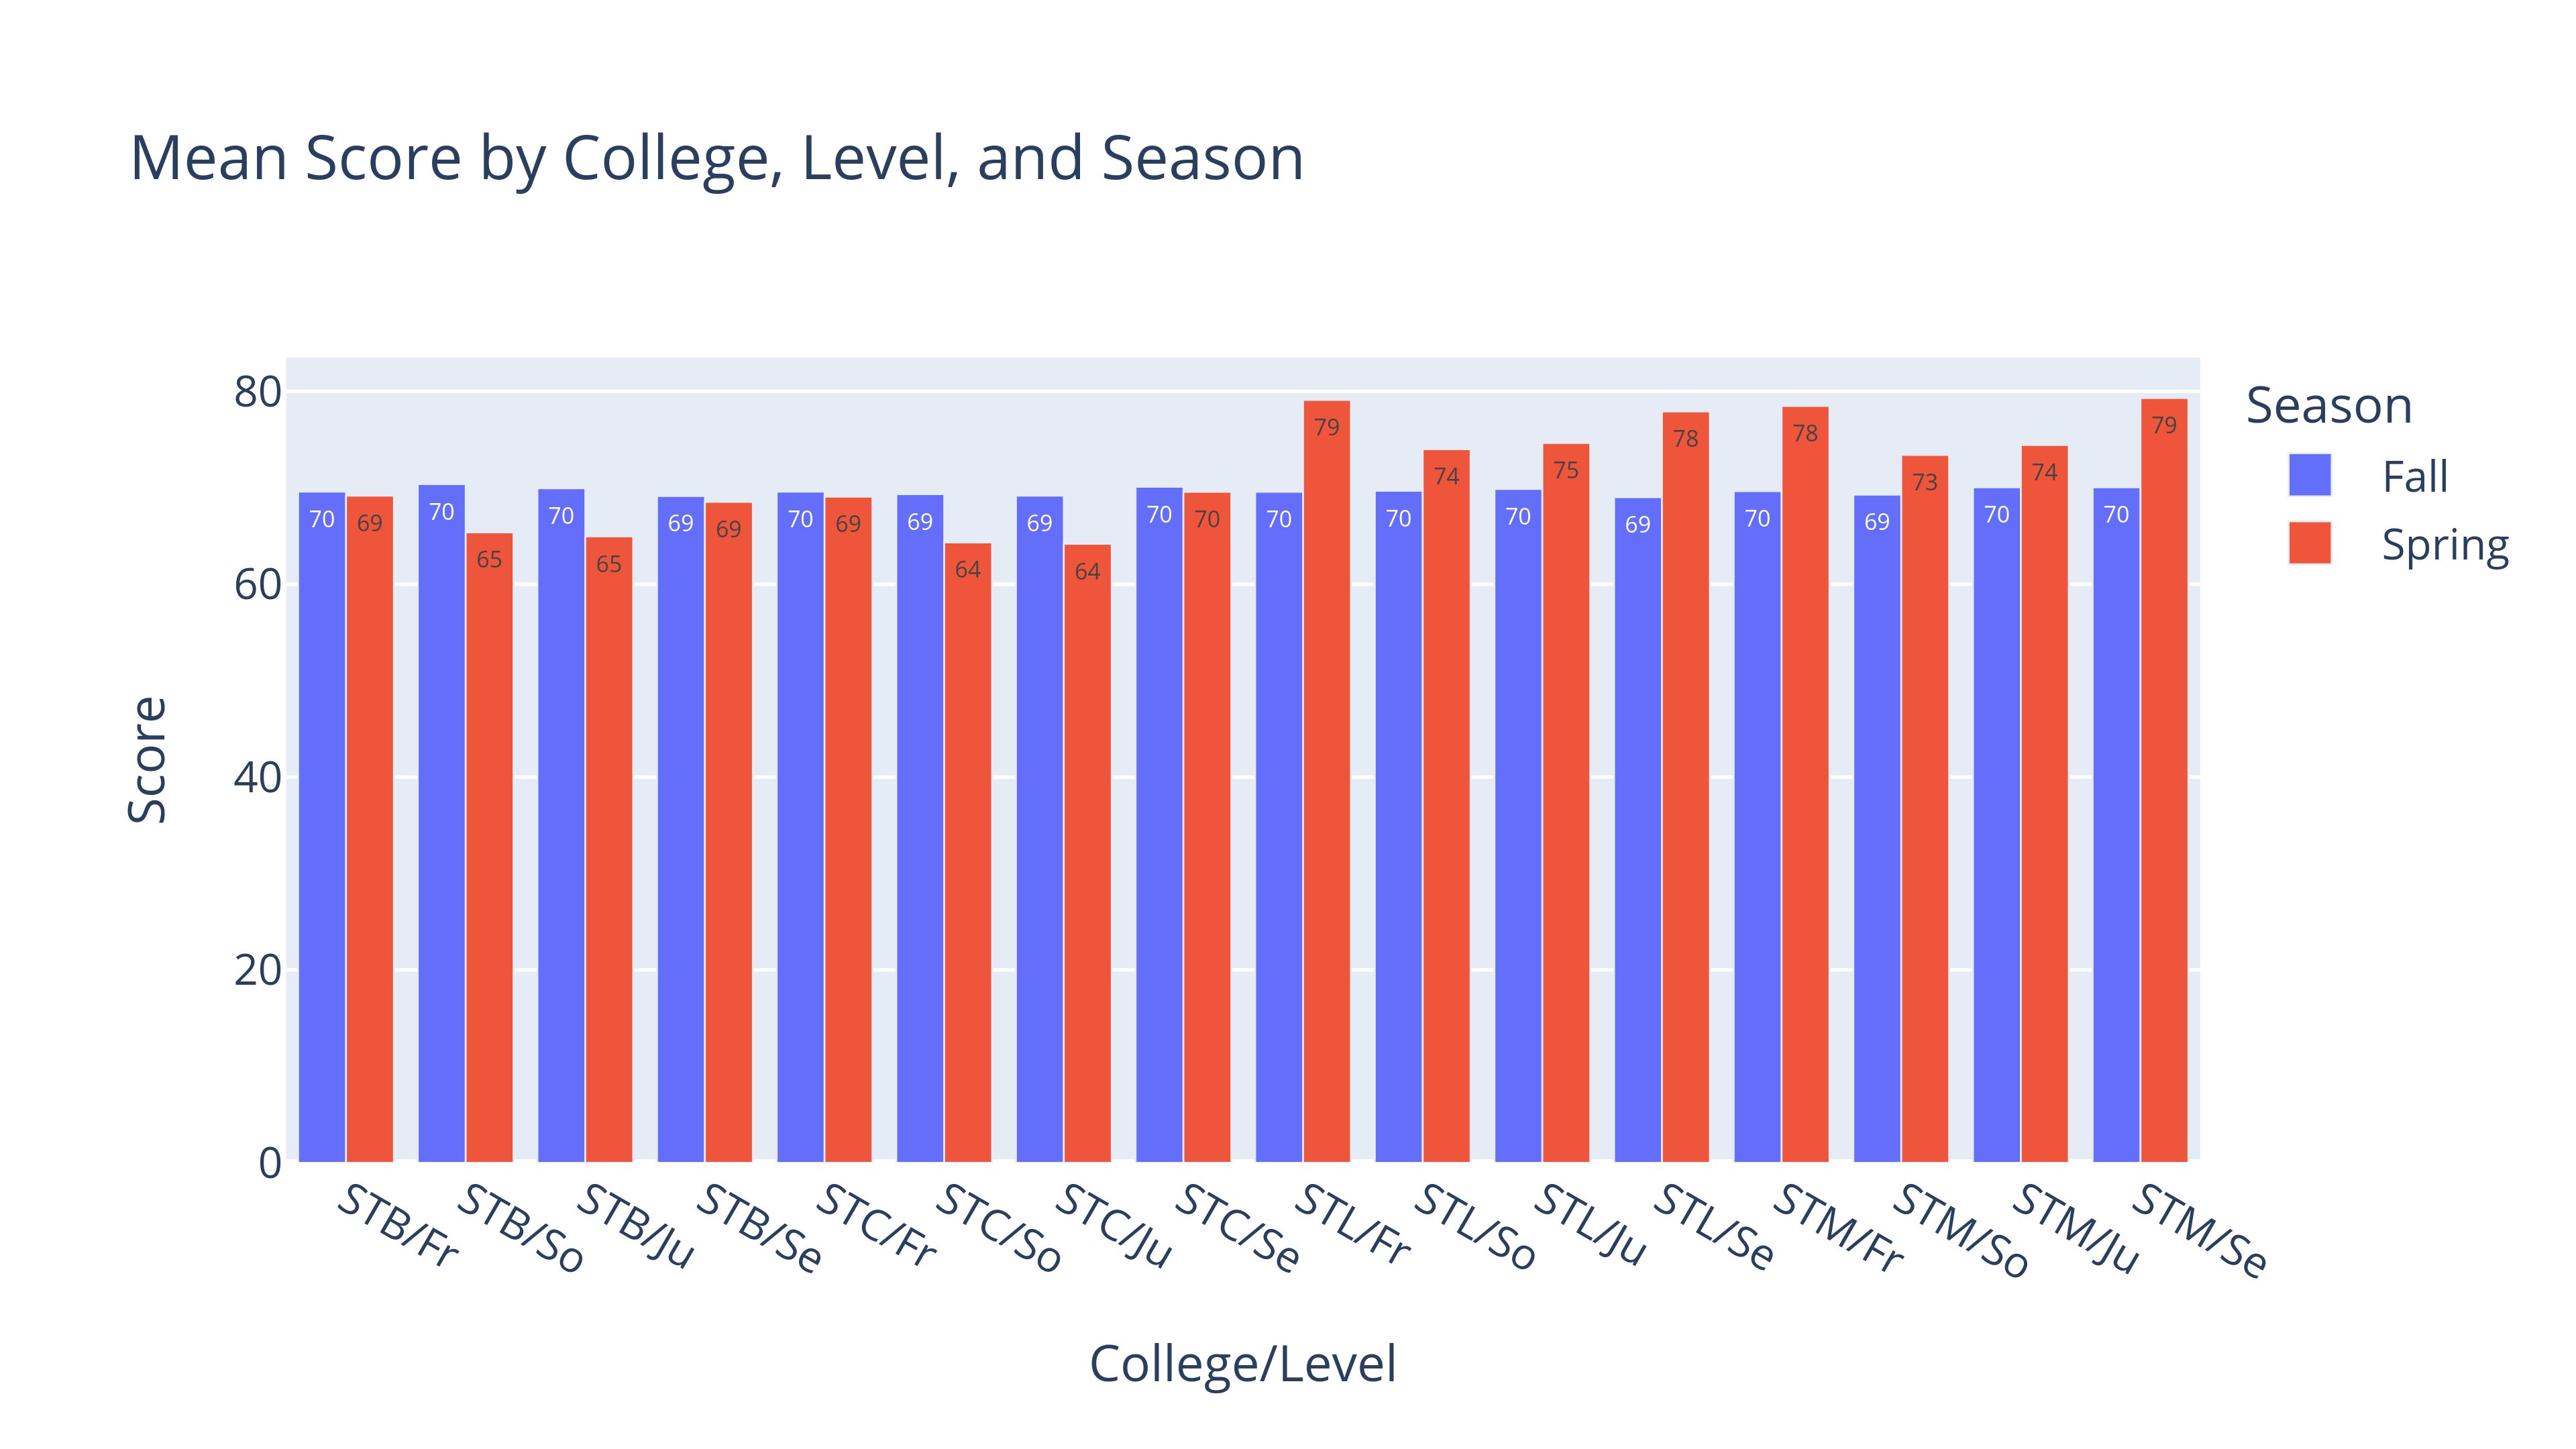

In [17]:
fig = autobar(
    df_pivot=df_pivot,
    x_val_name=x_val_name, y=y,
    color=color, barmode=barmode, 
    x_var_count=x_var_count, index=index,
    aggfunc=aggfunc,
    text_auto='.0f')

wadi(fig=fig, 
     file_path='output/mean_score_by_college_level_and_season_autopivot',
     display_type=display_type)
                               

This chart is certainly an improvement over our previous one. The levels now show up in the correct order (Fr, So, Ju, and Se), and the Season variable no longer appears within the x axis labels. (Since it's already featured within the legend, its presence there would be redundant.) In addition, our title now features better formatting also.

We can simplify this code even further by calling `autopivot_plus_bar()`:

x_vars: ['College', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['College', 'Level For Sorting', 'Level', 'Season']


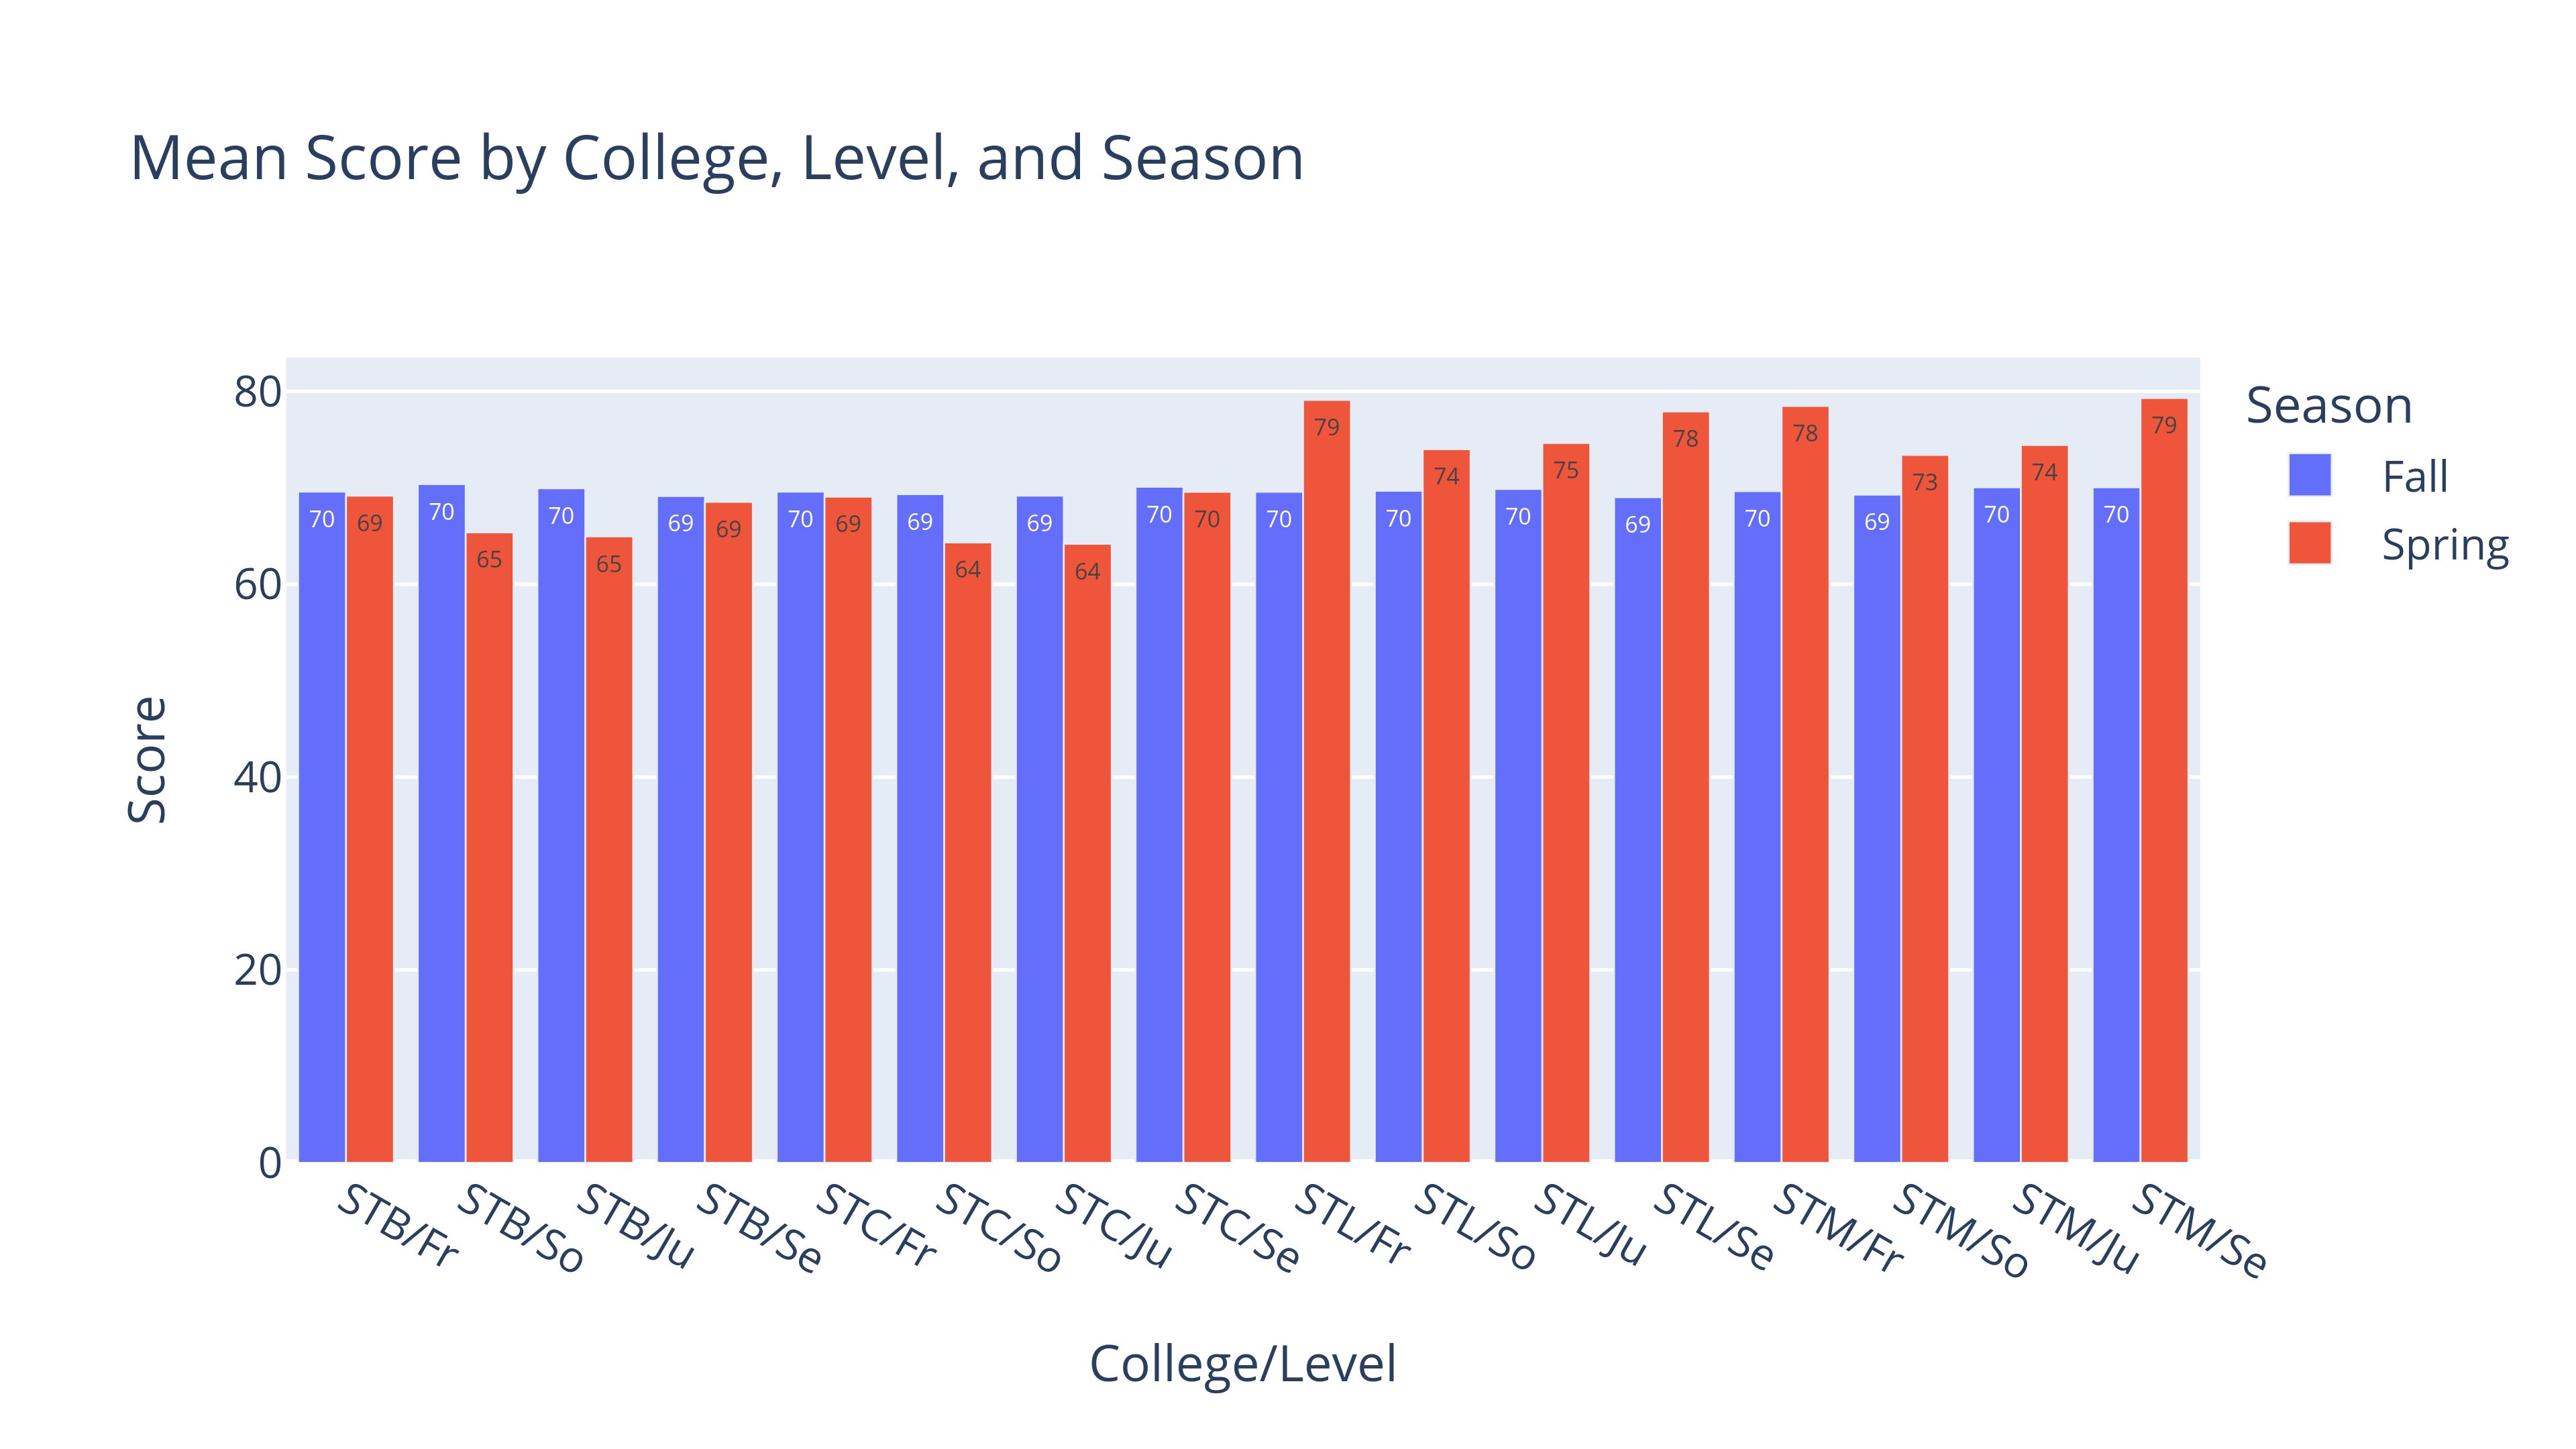

In [18]:
fig = autopivot_plus_bar(
    df=df_se, y='Score', 
    x_vars=['College', 'Level For Sorting', 'Level'], 
    color='Season', 
    x_vars_to_exclude=['Level For Sorting', 'Season For Sorting'],
    aggfunc='mean',
    text_auto='.0f')

wadi(fig=fig, 
     file_path='output/mean_score_by_college_level_and_\
season_autopivot_v2', display_type=display_type)

Here's an alternative chart with just 2 comparison variables: (This chart demonstrates how to use `autopivot_plus_bar()`'s `text_auto` argument to add extra precision to our text labels--though this level of detail is overkill in this case.

x_vars: ['Level', 'Season For Sorting']
index prior to pivot_table() call: ['Level', 'Season For Sorting', 'Season']


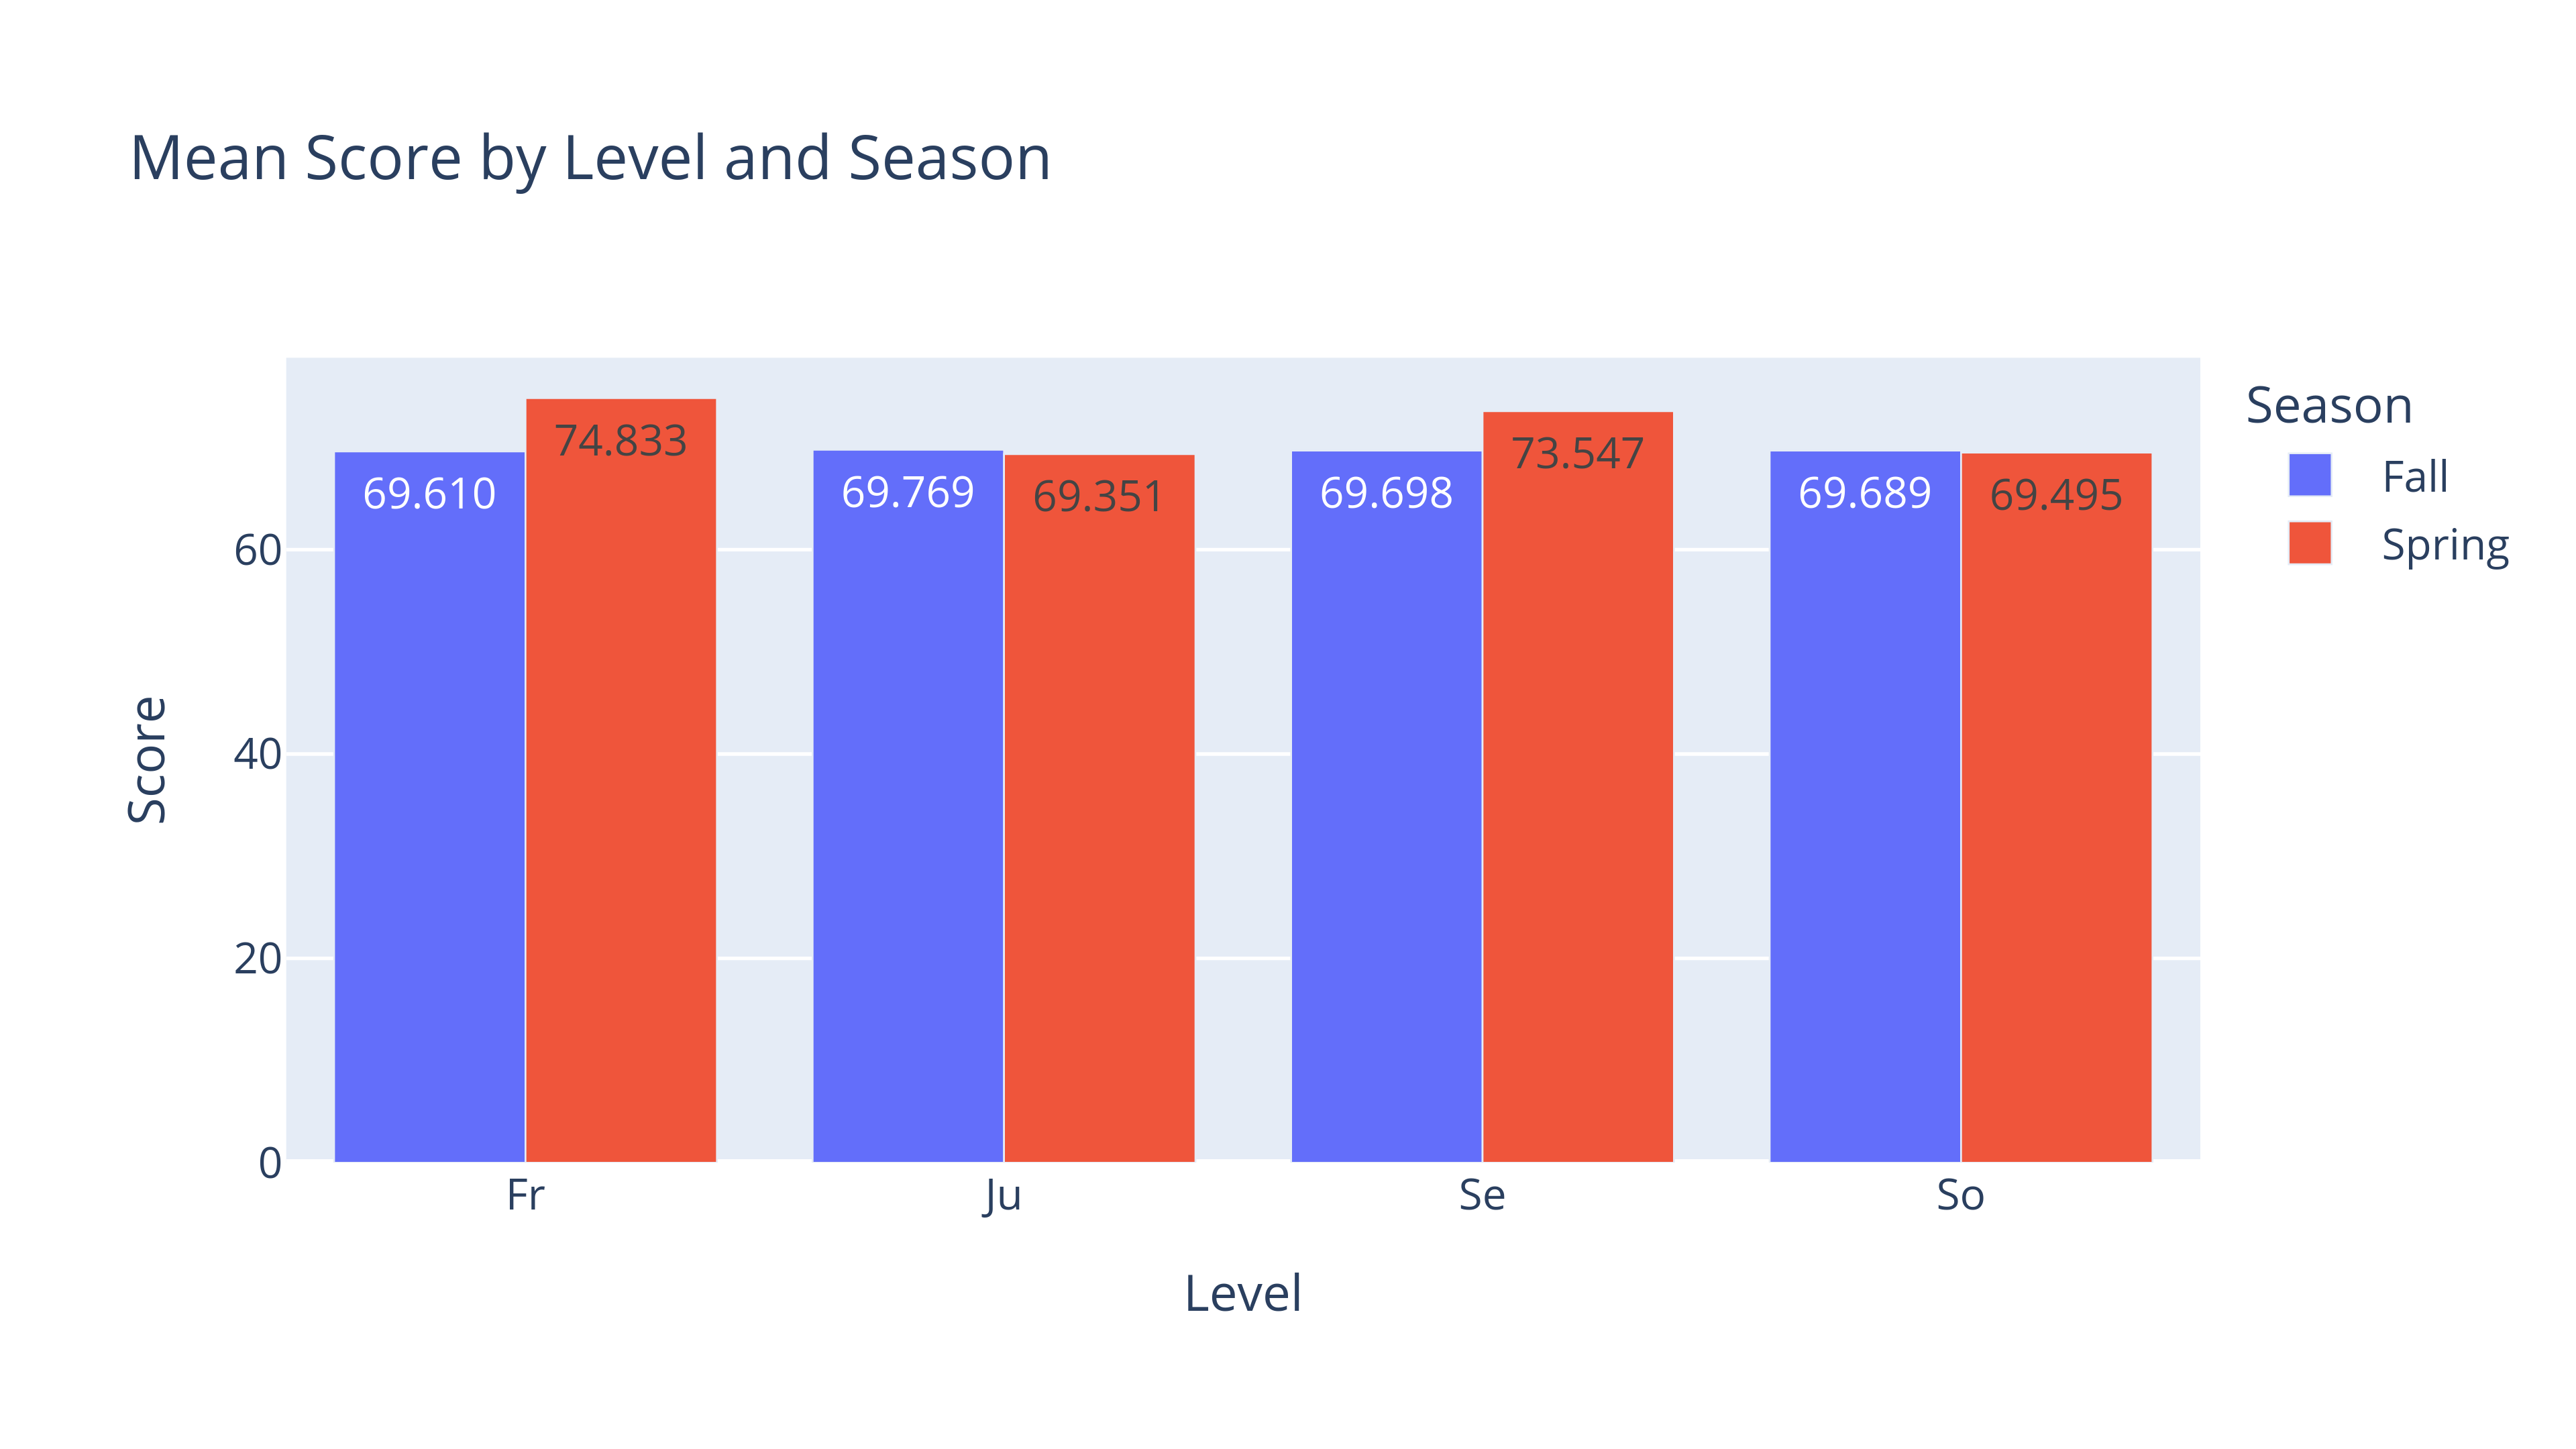

In [19]:
fig = autopivot_plus_bar(
    df=df_se, y='Score', 
    x_vars=['Level', 'Season For Sorting'], 
    color='Season', 
    x_vars_to_exclude=['Season For Sorting'],
    aggfunc='mean',
    text_auto='.3f')

wadi(fig=fig, 
     file_path='output/mean_score_by_level_and_season_autopivot', 
     display_type=display_type)

Note that the above output is identical to the output of the following cell, which uses an aggregated dataframe (`df_se_pivot`) as its data source. This identical output was achieved by adding in a weight column (`Responses`).

x_vars: ['Level']
index prior to pivot_table() call: ['Level', 'Season']


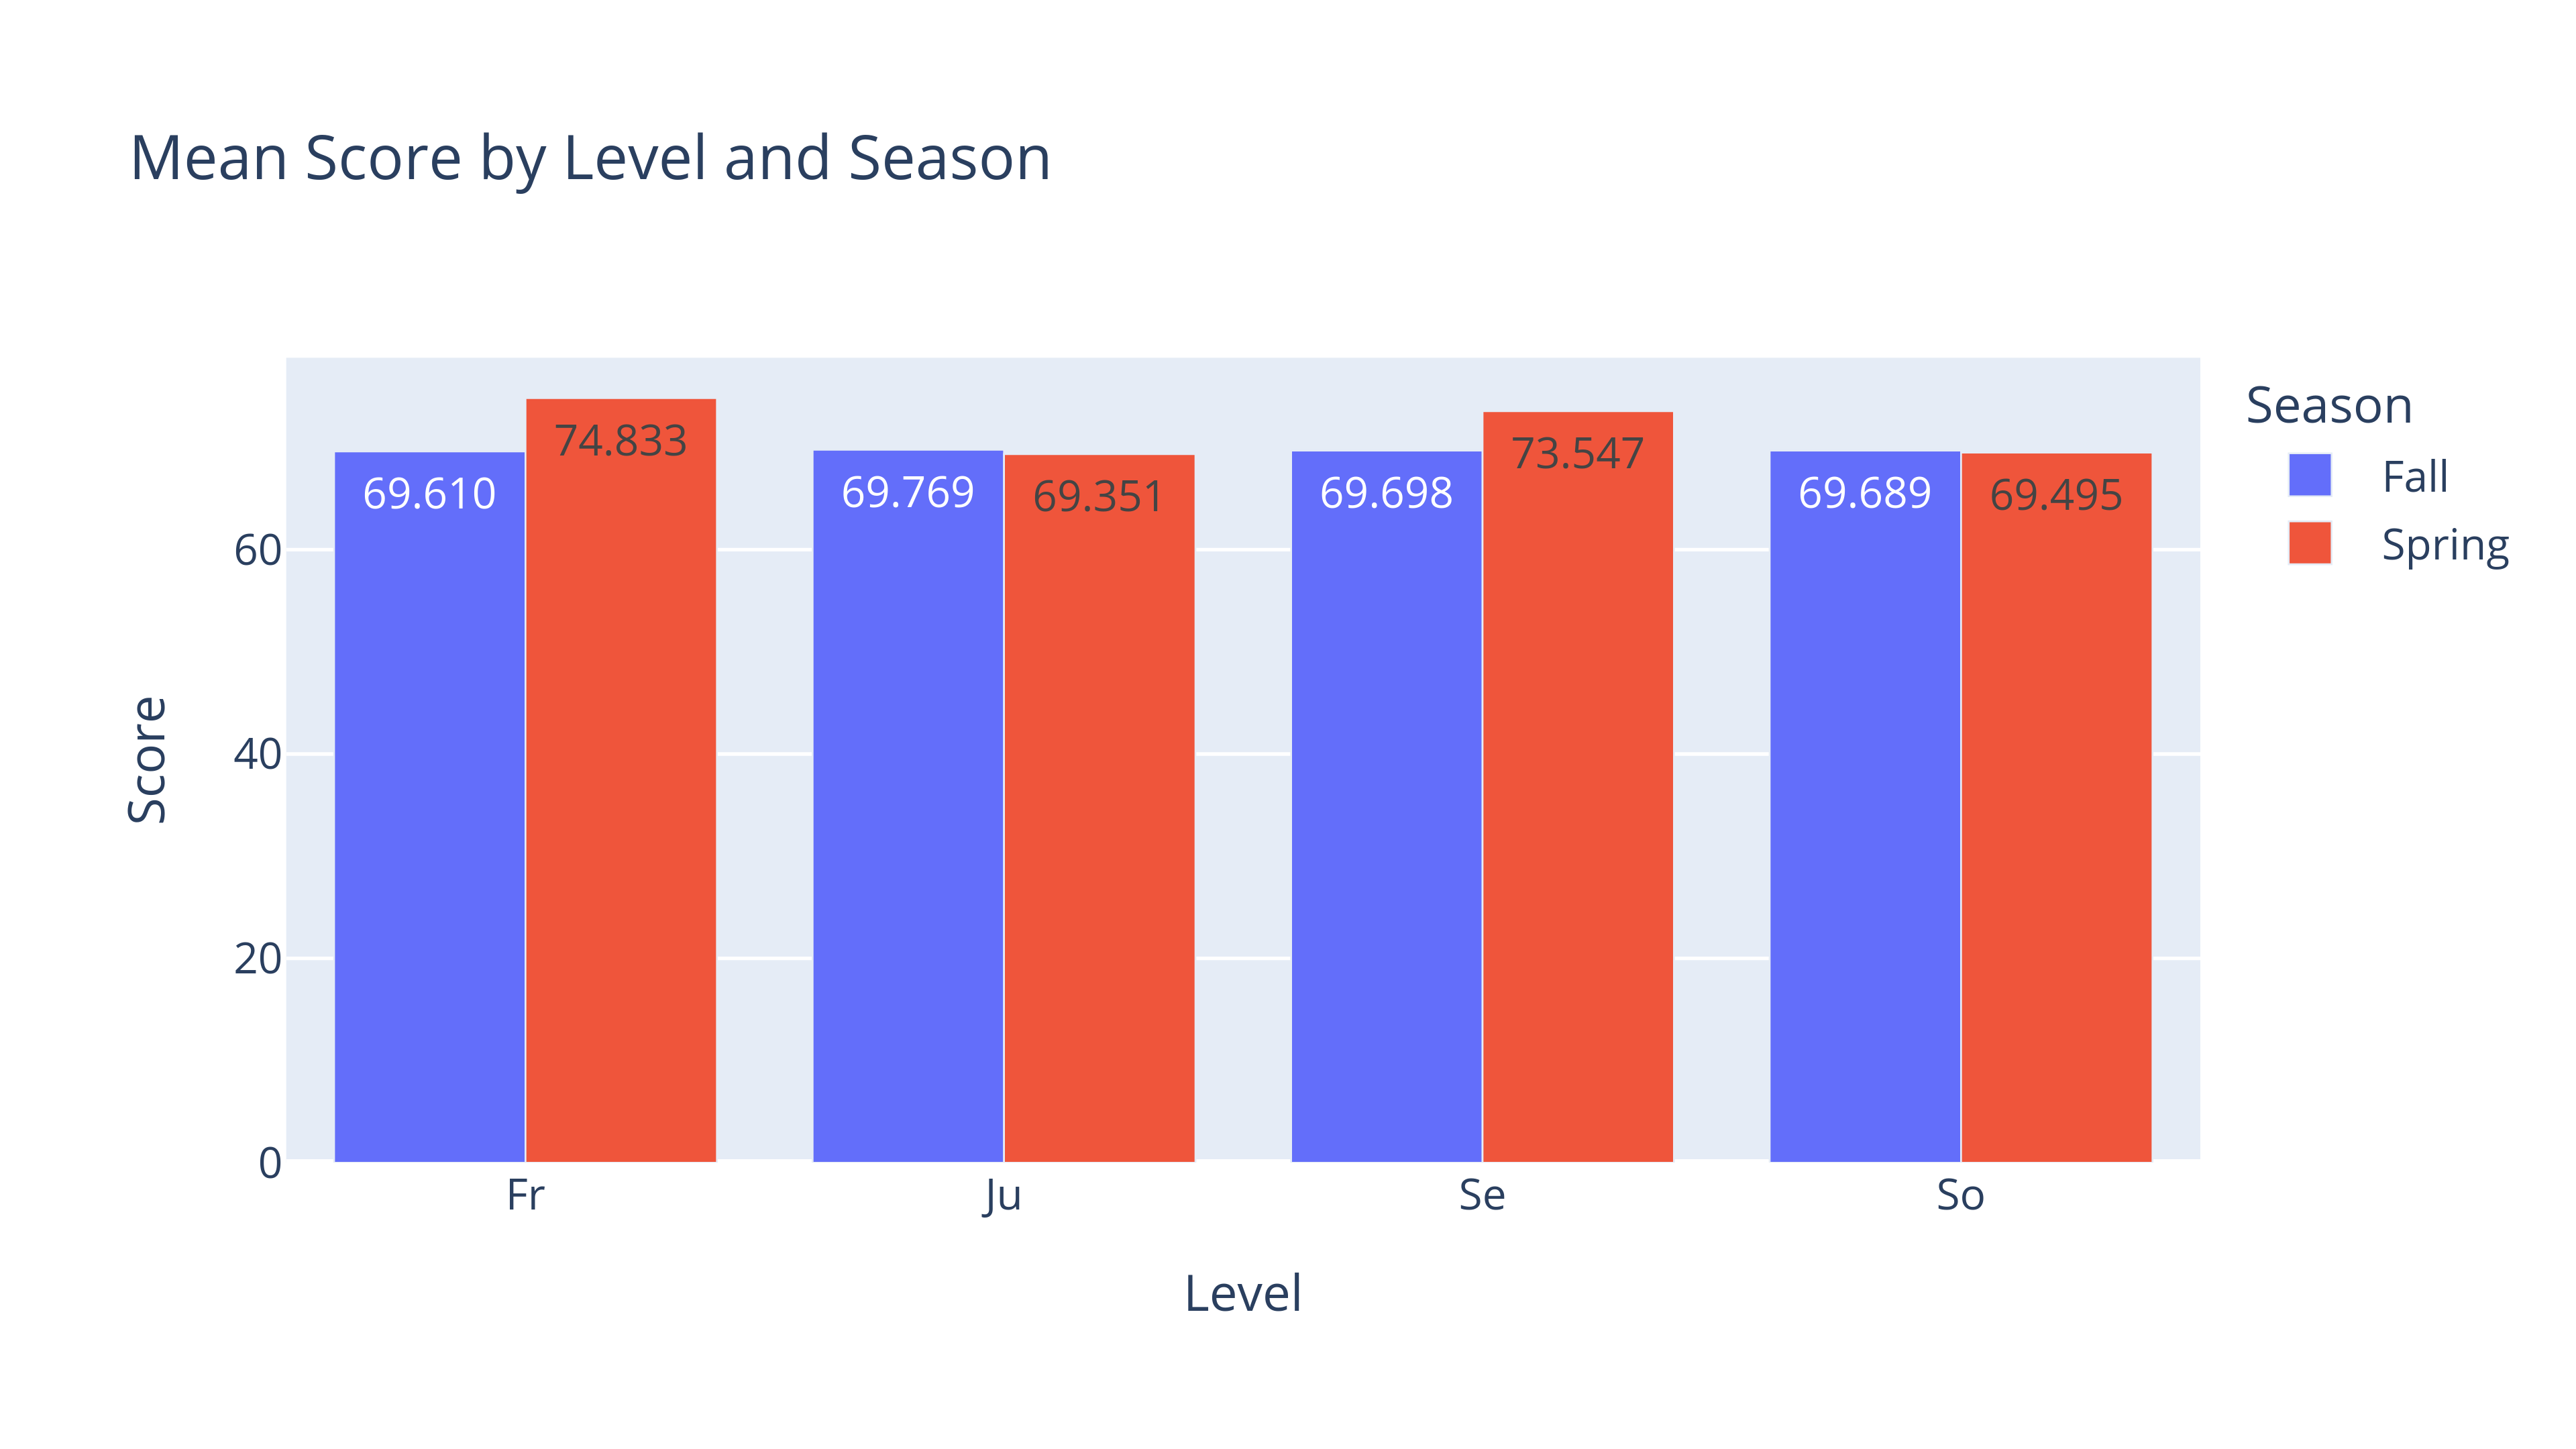

In [20]:
fig = autopivot_plus_bar(
    df=df_se_pivot, y='Score', 
    x_vars=['Level'], 
    color='Season', 
    x_vars_to_exclude=['Season For Sorting'],
    aggfunc='mean', weight_col='Responses',
    text_auto='.3f')        

wadi(fig=fig, 
     file_path='output/mean_score_by_level_and_season_autopivot_v2', 
     display_type=display_type)

In contrast, the following output, which uses df_se_pivot as well but does *not* reference a weight column, differs slightly from the above two graphs. This is because it is falling into the 'average of averages' error noted within Descriptive Stats: Part 2.

x_vars: ['Level']
index prior to pivot_table() call: ['Level', 'Season']


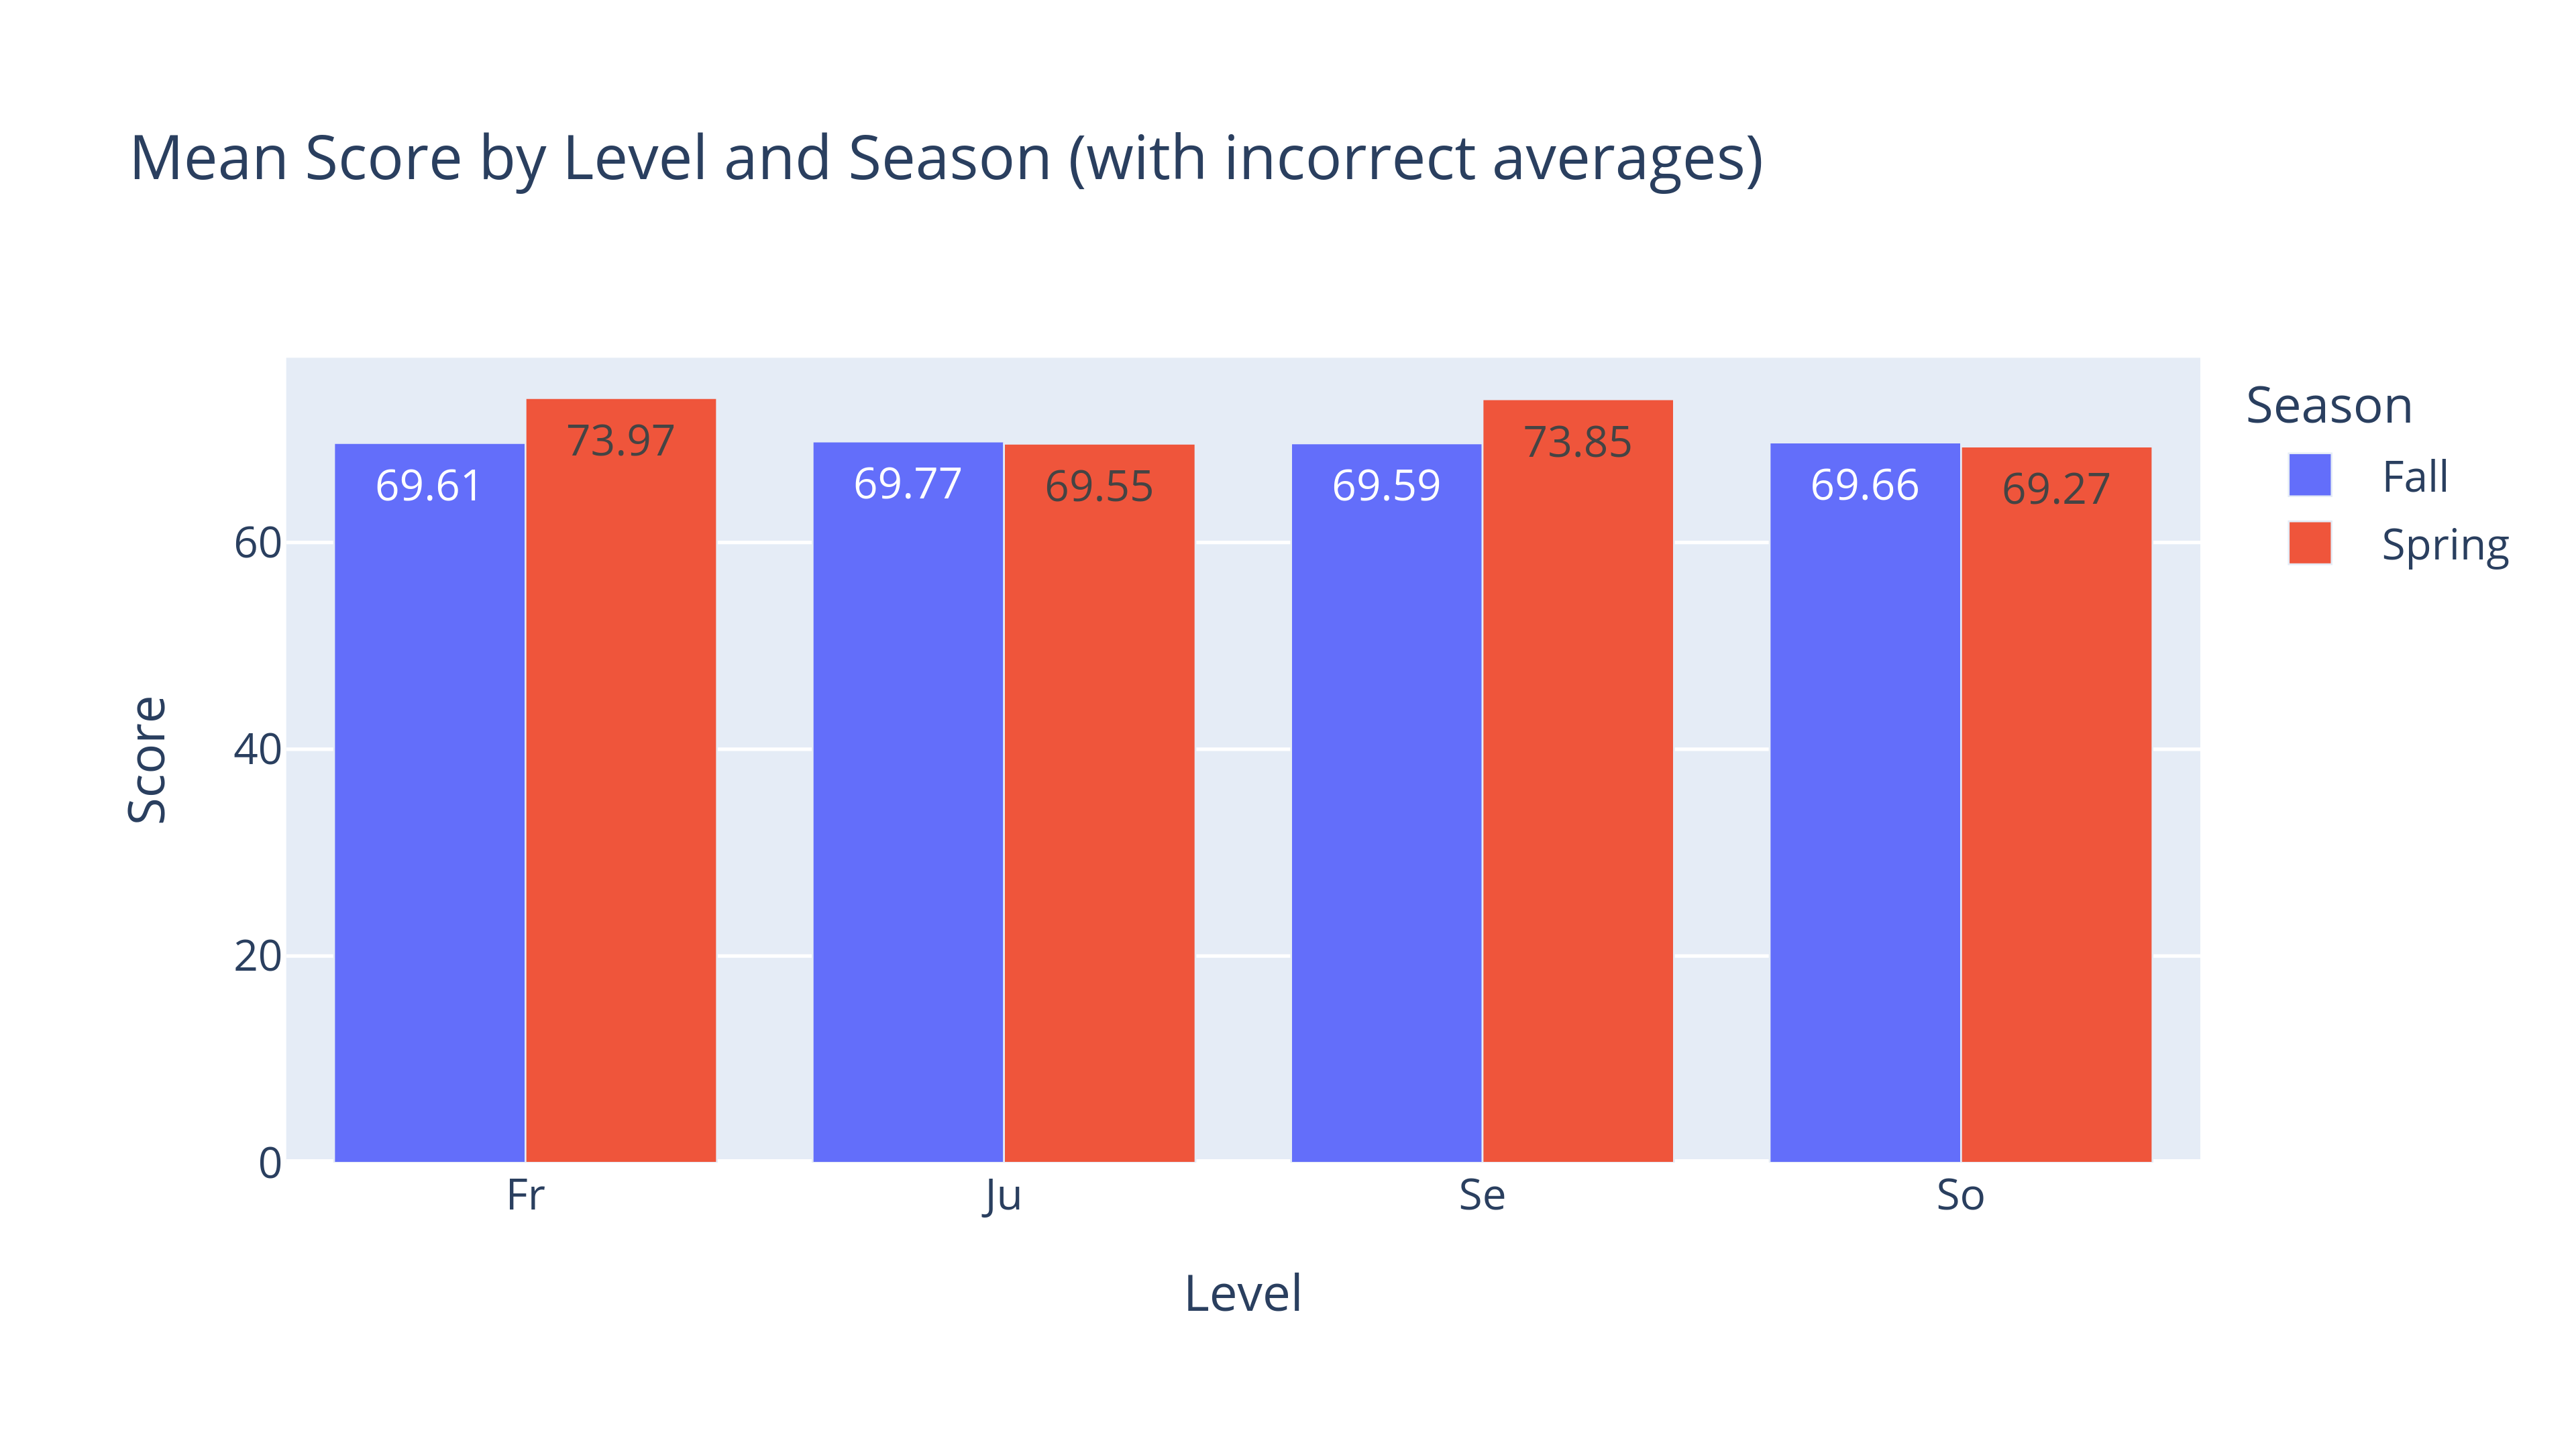

In [21]:
fig = autopivot_plus_bar(
    df=df_se_pivot, y='Score', 
    x_vars=['Level'], 
    color='Season', 
    x_vars_to_exclude=['Season For Sorting'],
    aggfunc='mean').update_layout(title='Mean Score by Level and \
Season (with incorrect averages)')

# As shown by this update_layout() call, further modifications can be 
# made as needed to figures returned by autopivot_plus_bar().

wadi(fig=fig, 
     file_path='output/mean_score_by_level_and_season_autopivot_aoa_error', 
     display_type=display_type)

These functions also allow the color argument to be skipped, though the result is rather plain:

x_vars: ['College', 'Level']
index prior to pivot_table() call: ['College', 'Level']


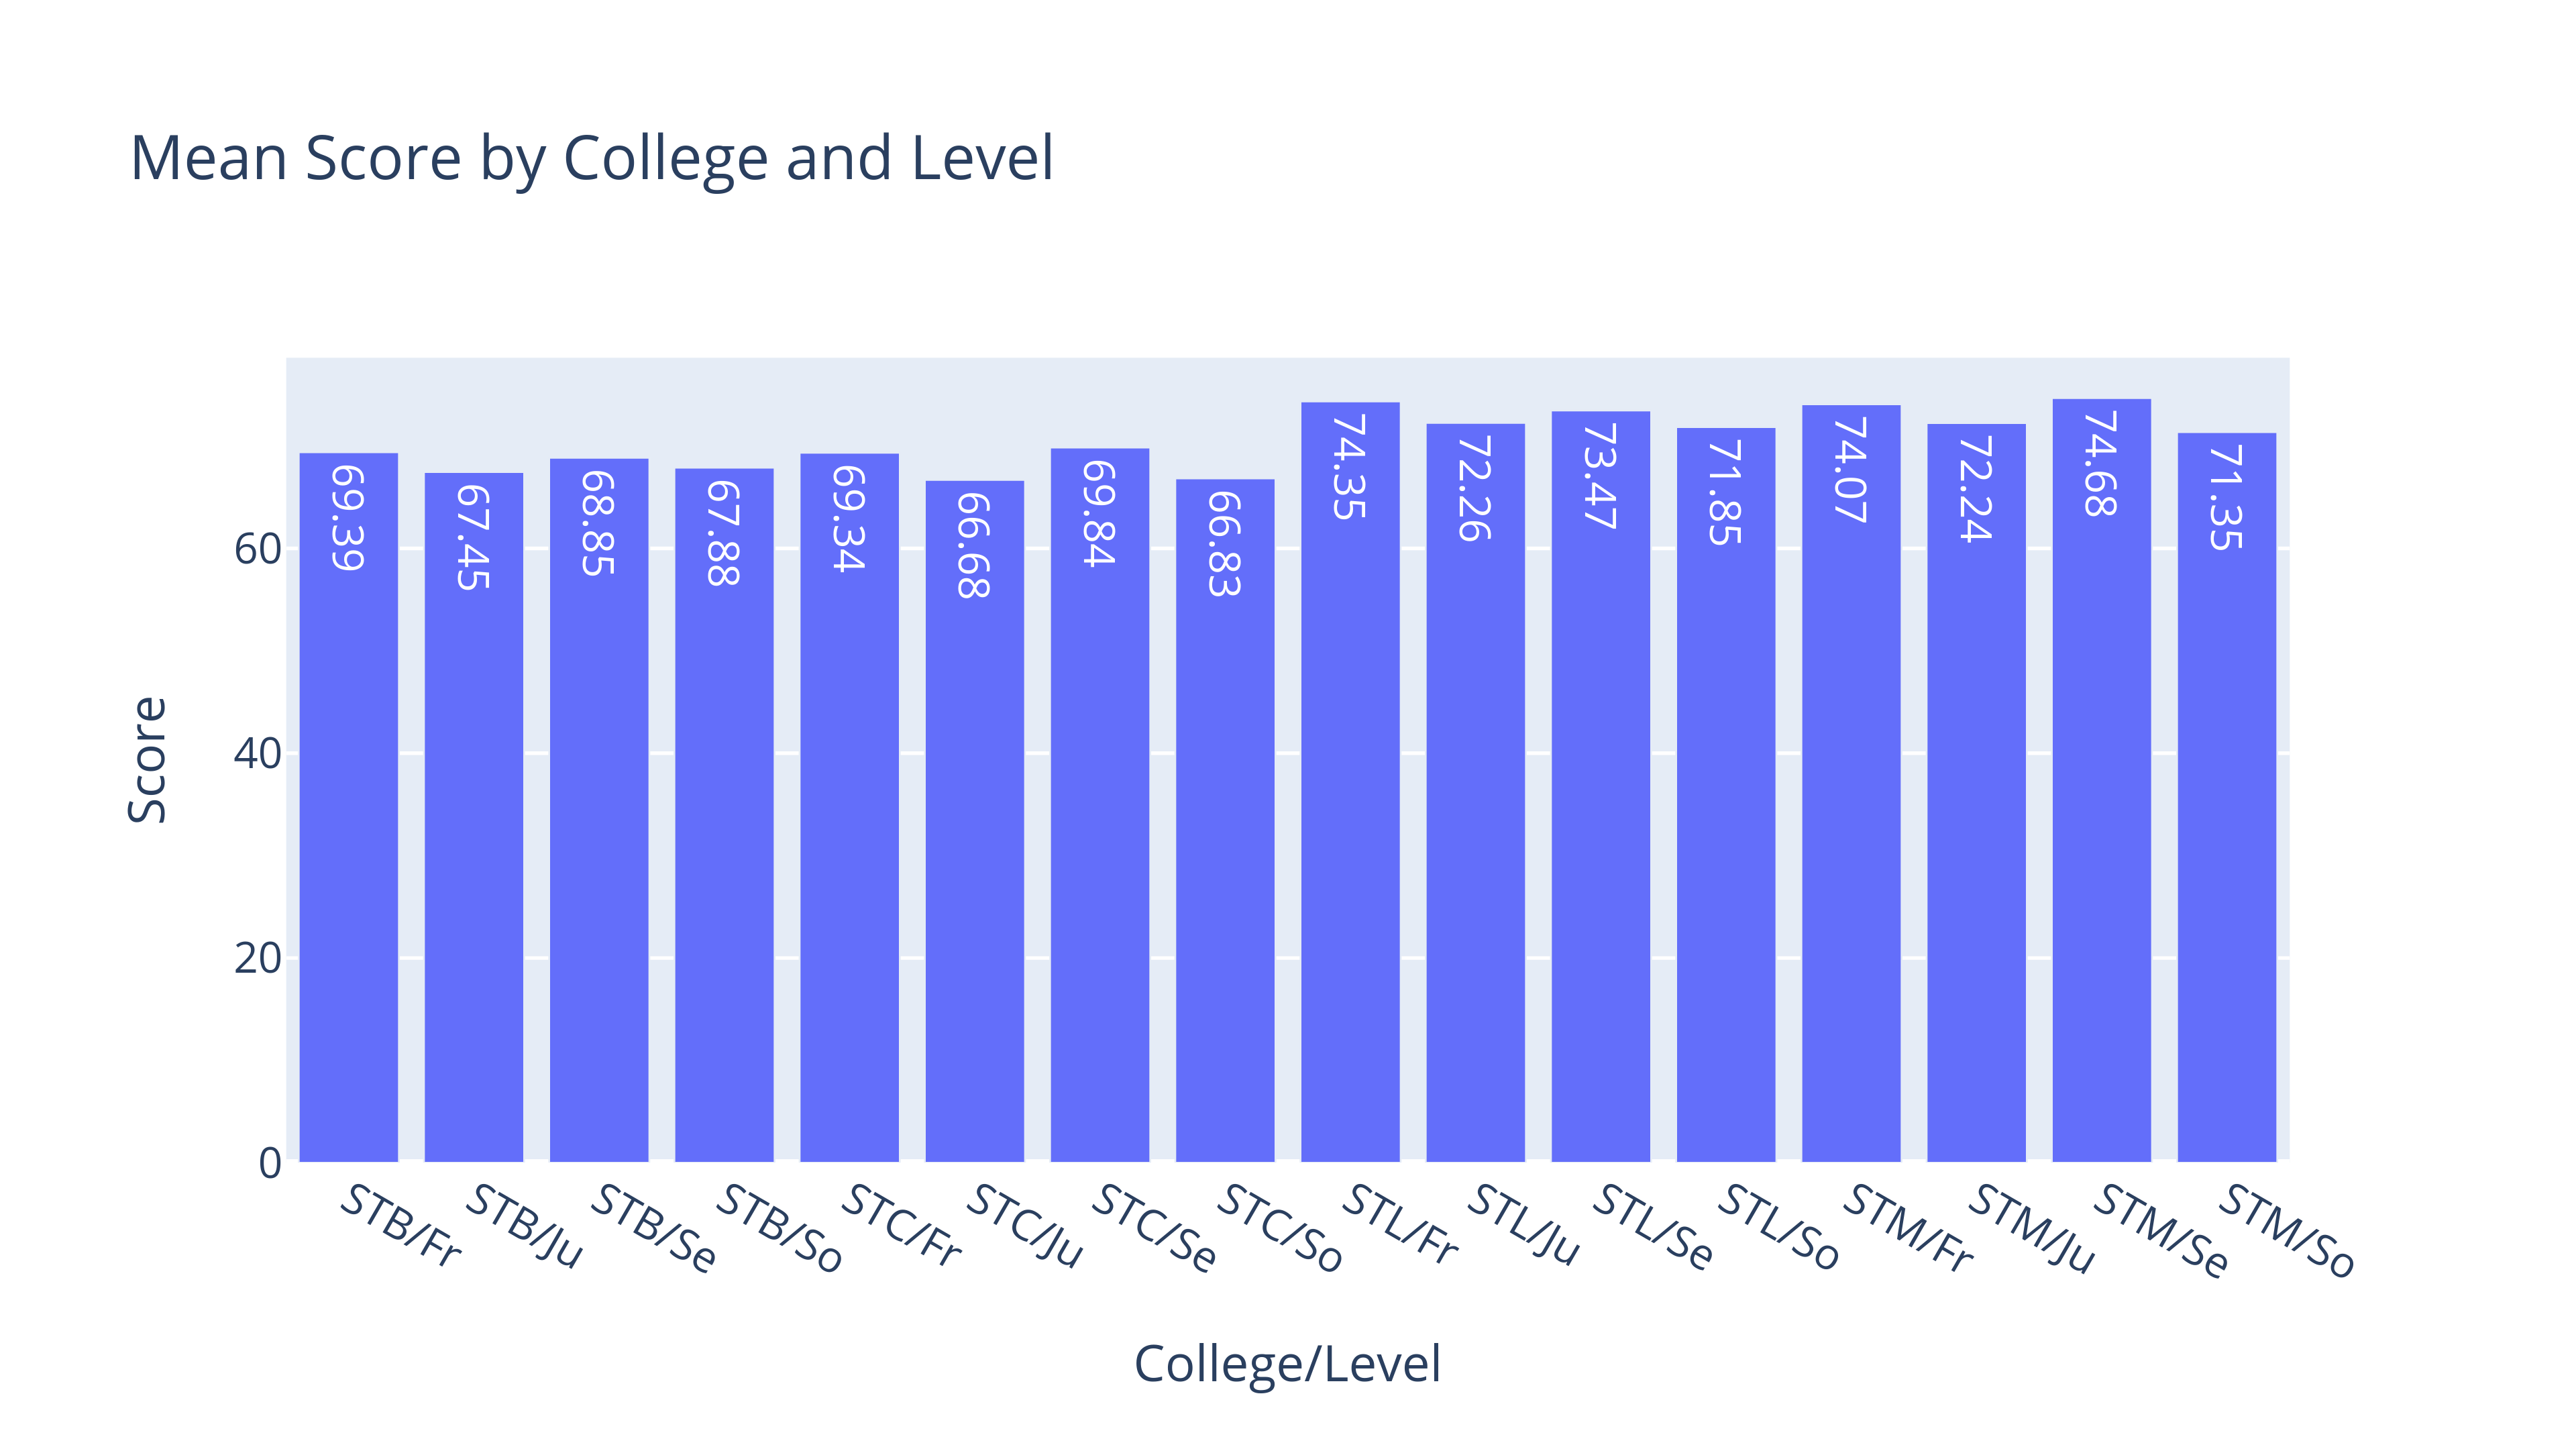

In [22]:
fig = autopivot_plus_bar(
    df=df_se, y='Score', 
    x_vars=['College', 'Level'],
    aggfunc='mean')

wadi(fig=fig, 
     file_path='output/mean_score_by_college_and_level_\
autopivot_colorless', 
     display_type=display_type)

They also allow an empty list of comparison values to get passed to x_vars, thus producing a single bar that represents the average of all values in the DataFrame.

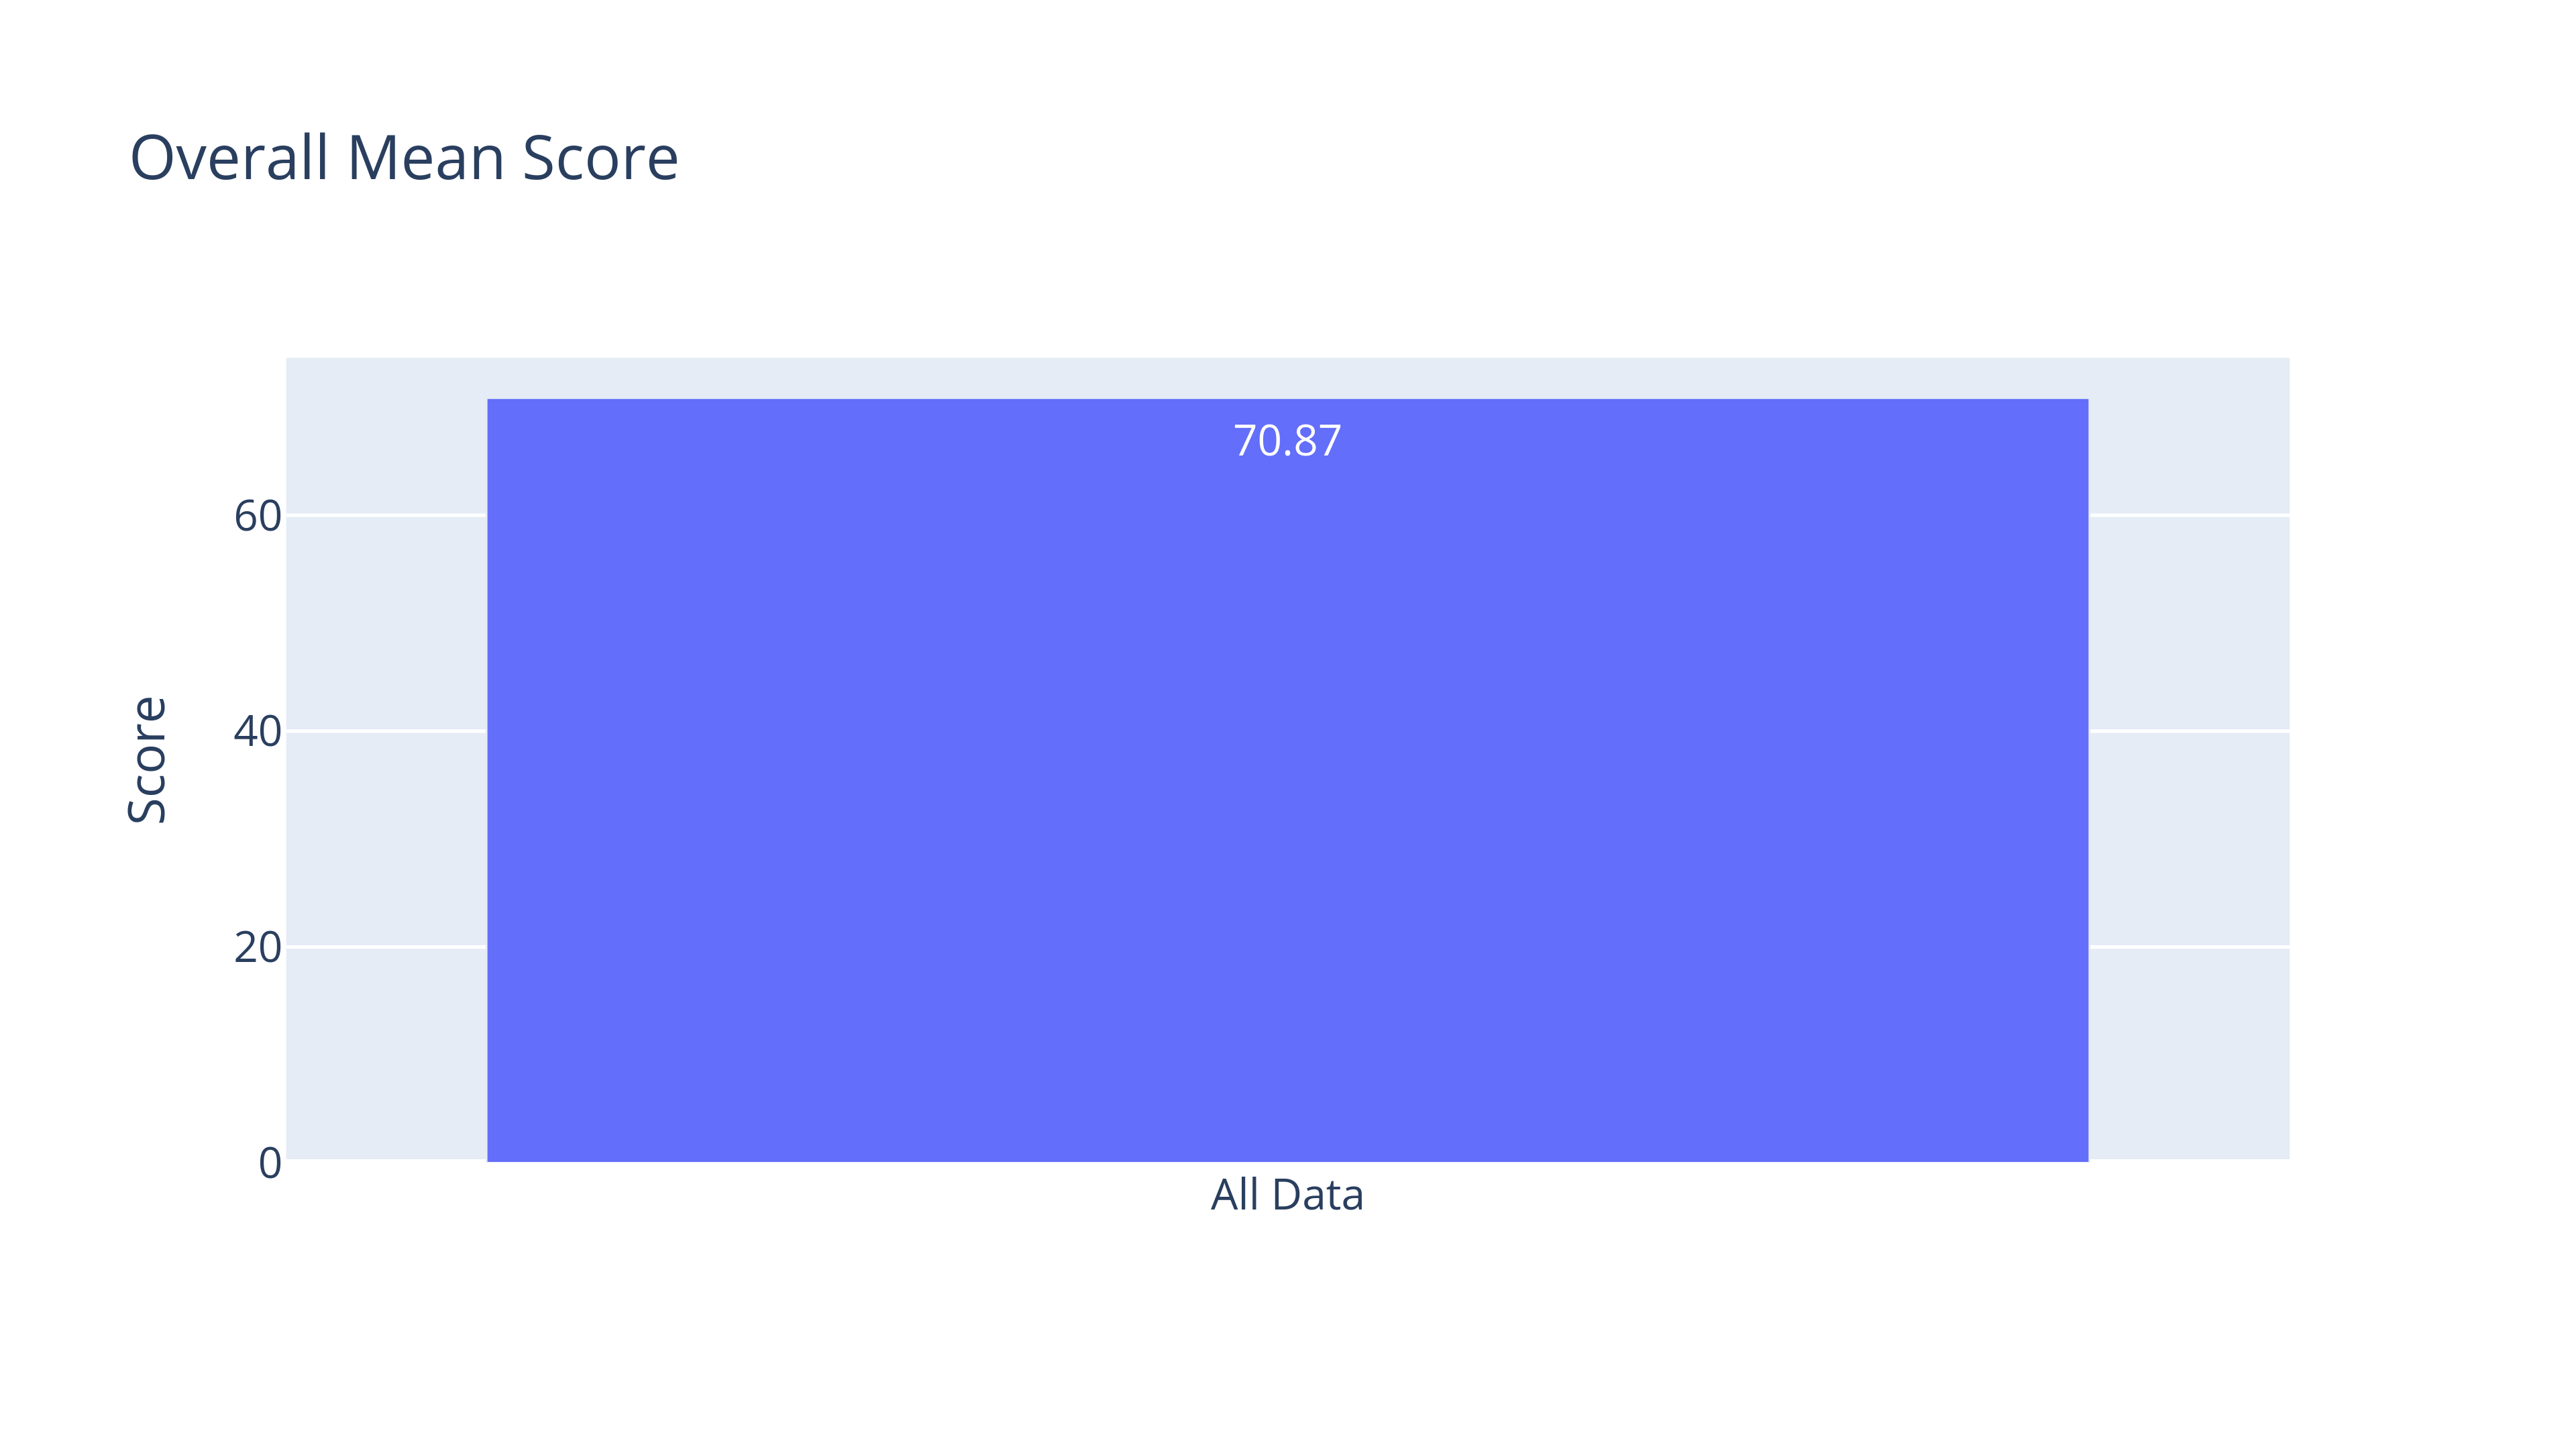

In [23]:
fig = autopivot_plus_bar(
    df=df_se, y='Score', 
    x_vars=[], 
    color=None, 
    x_vars_to_exclude=[],
    aggfunc='mean')       

wadi(fig=fig, 
     file_path='output/overall_mean_score_autopivot', 
     display_type=display_type)

At the opposite extreme, we can graph 6 comparison variables within the same chart (though the result is not the easiest to read):

x_vars: ['Starting Year', 'Gender', 'College', 'Class Of', 'Level For Sorting', 'Level']
index prior to pivot_table() call: ['Starting Year', 'Gender', 'College', 'Class Of', 'Level For Sorting', 'Level', 'Season']


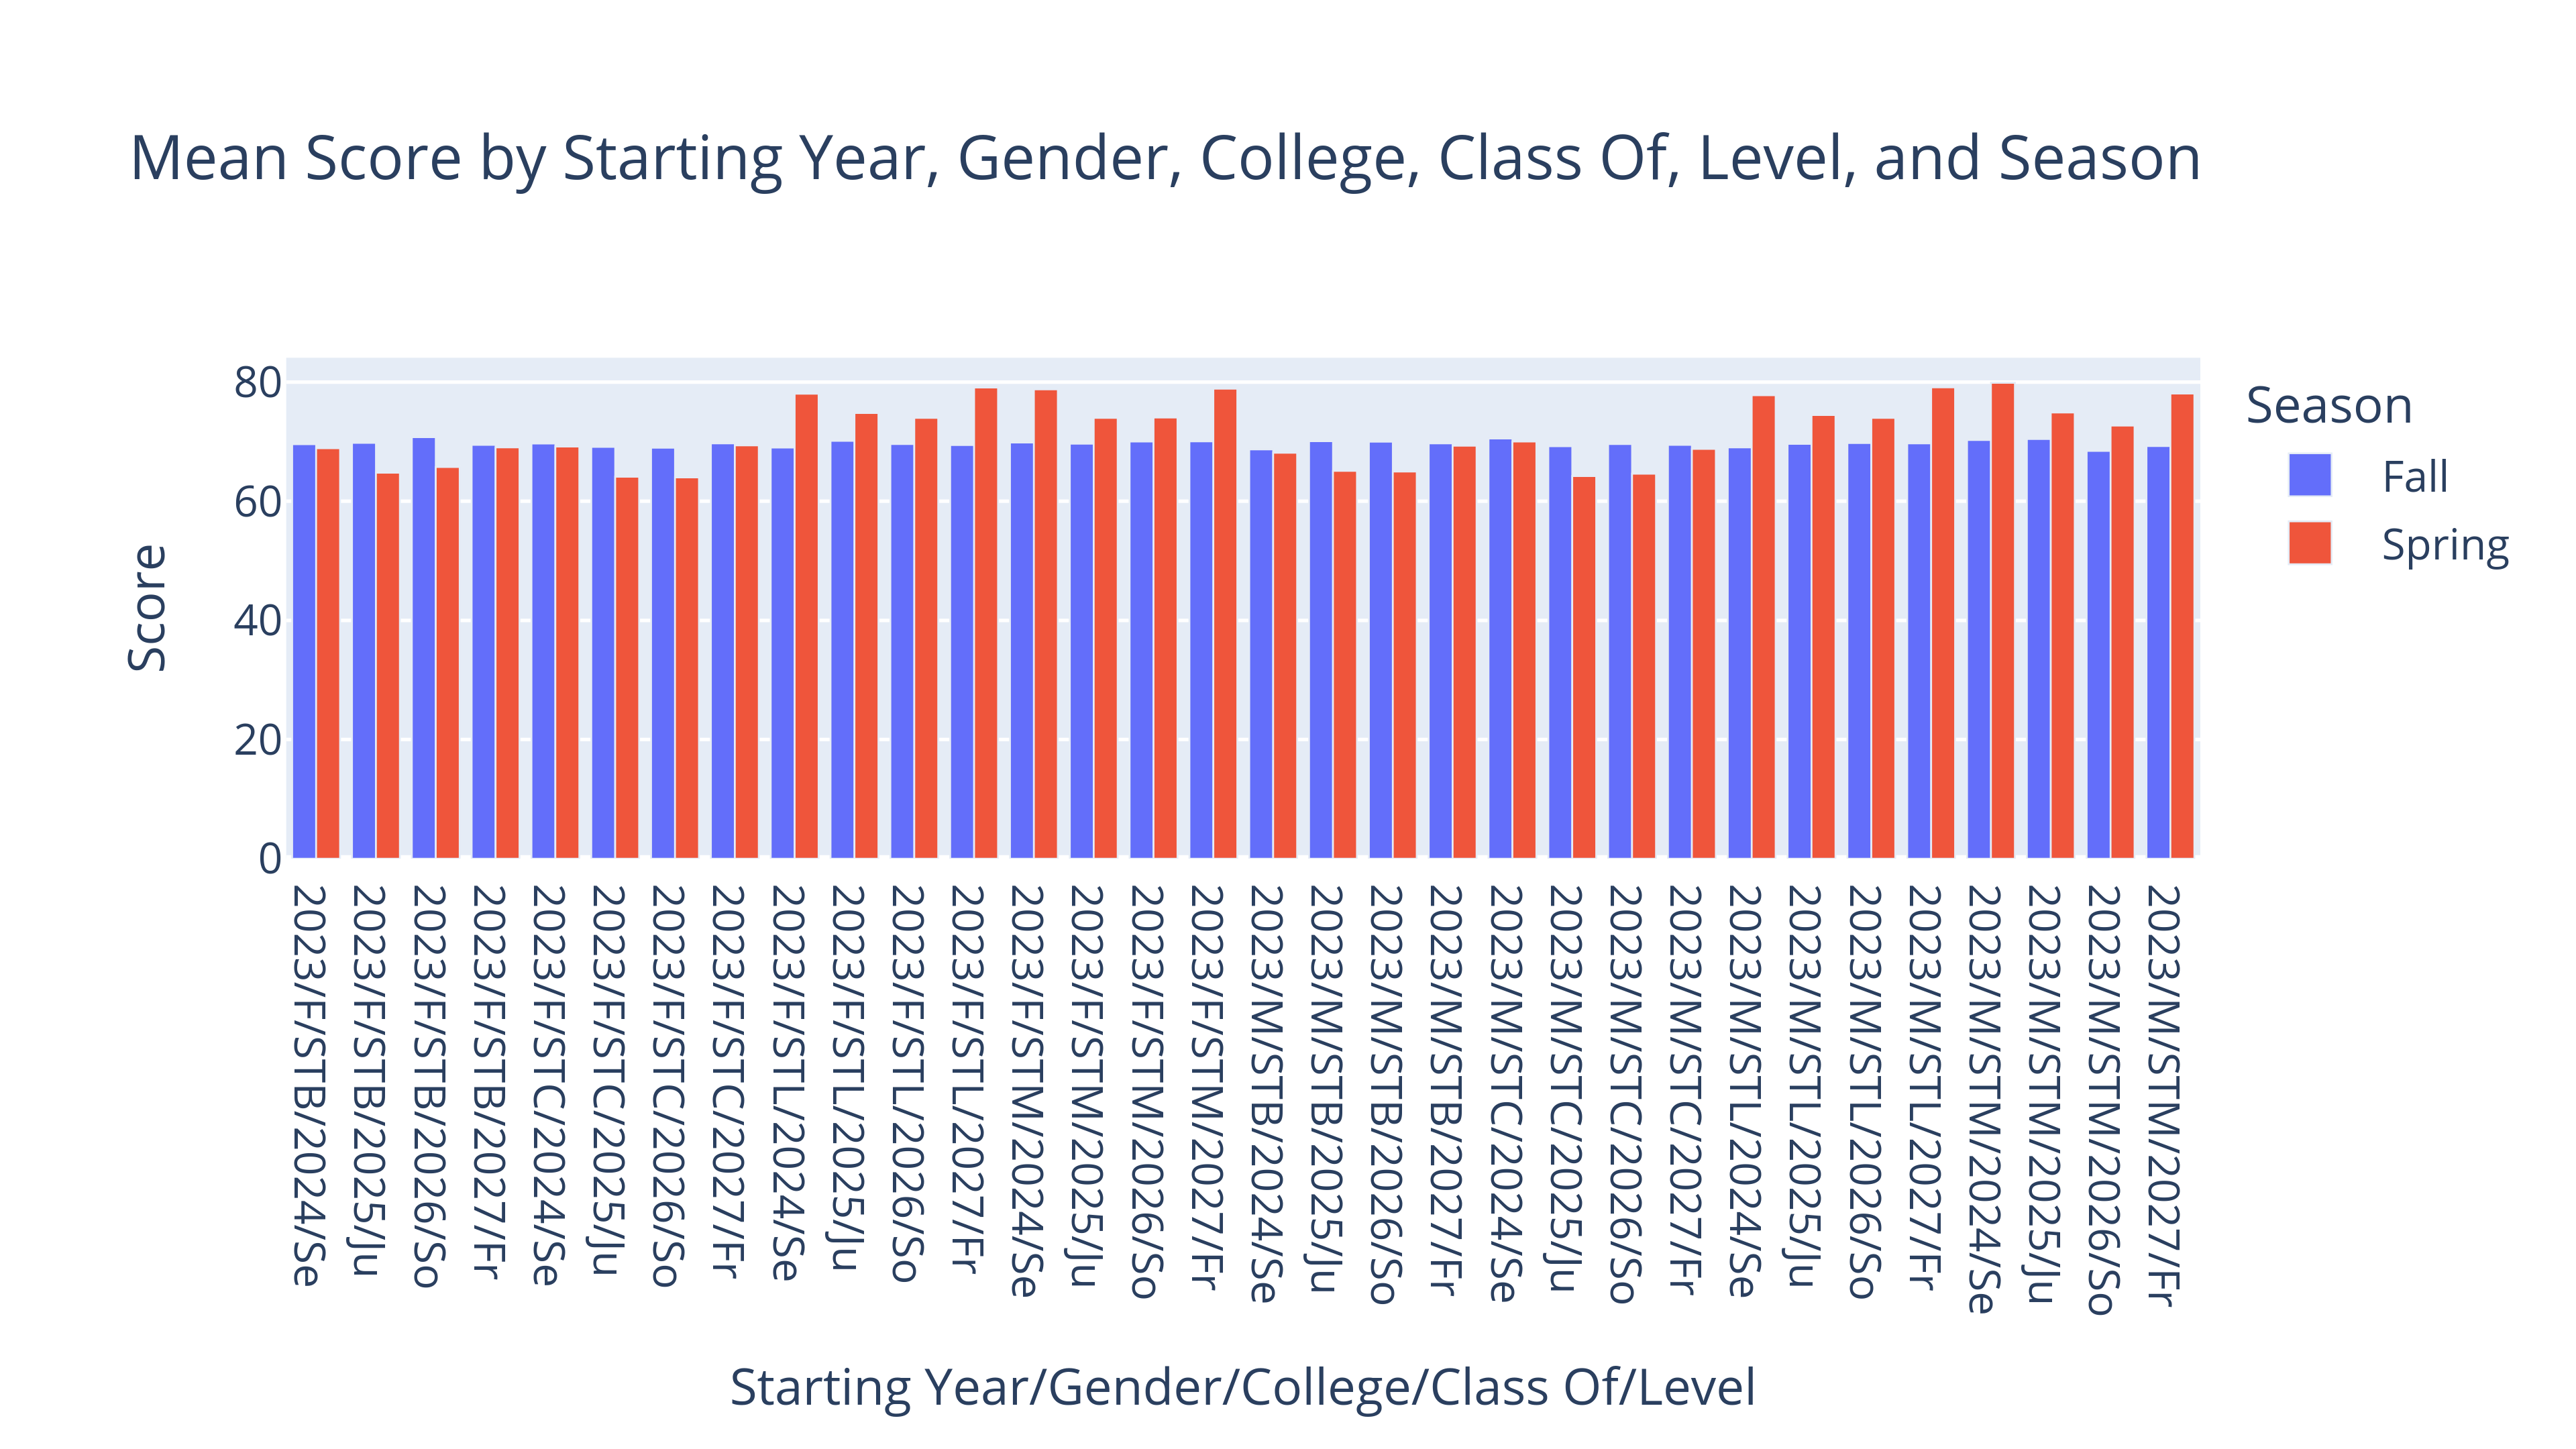

In [24]:
fig = autopivot_plus_bar(
    df=df_se, y='Score', 
    x_vars=[
        'Starting Year', 'Season', 'Gender', 'College', 'Class Of', 
        'Level For Sorting', 'Level'], 
    color='Season', 
    x_vars_to_exclude=['Level For Sorting'],
    aggfunc='mean', text_auto=False)      

wadi(fig=fig, 
     file_path='output/mean_score_by_6_variables_autopivot', 
     display_type=display_type)

## Conclusion

The `autopivot()`,  `autobar()`, and `autopivot_plus_bar()` functions shown here can help speed up the process of creating standalone Plotly charts. However, these functions will prove even more useful within the Online Visualizations section of Python for Nonprofits--as they'll allow us to turn a small set of user inputs into a wide variety of charts and tables.

Now that we've learned how to use Plotly to create various types of charts, we'll shift our focus to mapping--an area in which Plotly also excels.